In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Iterable, Union, List, Tuple, Dict, Optional
from tqdm.notebook import tqdm, trange
from functools import partial

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
az.style.use("arviz-darkgrid")

In [2]:
from scipy.special import softmax
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
import shap
# sklearn imports (OLS, Lasso, Ridge, k-fold-CV)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pymc as pm

# Data
* read data
* extract general info.
* remove non-informative/redundant features/labels
* train-test split

In [3]:
df = pd.read_csv('../data/kc_house_data.csv', parse_dates=[1])  # parse date column
print(df.shape)
df.head()

(21613, 21)


id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [5]:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000  
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652  
std       53.505026      0.138564      0.140828     685.391304   27304.179631  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [6]:
# predict log_price instead of price (normal distributed)
df["log_price"] = np.log(df['price'])

# drop non-informative columns
df = df.drop(["id", "waterfront", "yr_renovated", "lat", "long"], axis=1)

In [7]:
# train-test split (80-20)
threshold_date = df["date"].quantile(q=0.8)
print(f'{threshold_date=}')

df_train = df[df['date']  <= threshold_date].copy()
df_test = df[df['date']  > threshold_date].copy()

threshold_date=Timestamp('2015-03-10 00:00:00')


# Feature Engineering

## Transformations
* add one-hot encoding for zipcode for the naive models

In [8]:
def convert_col2cat(df: pd.DataFrame, col: str, bins: Union[Iterable,int],
                    labels: Optional[Iterable]=None) -> Tuple[pd.Series, Dict[str, str]]:
    cat_col = pd.cut(df[col], bins=bins, labels=labels)
    mapping = dict(zip(cat_col.cat.codes, cat_col))
    cat_col = cat_col.cat.codes
    return cat_col, mapping

In [9]:
# regroup bedrooms, bathrooms, floors, grade
df_train['grouped_bedrooms'], bedrooms_encode2cat = convert_col2cat(df_train, col="bedrooms", bins=[-0.001, 2, 3, 4, 50])
df_train['grouped_bathrooms'], bathrooms_encode2cat = convert_col2cat(df_train, col="bathrooms", bins=[-0.001, 1, 2, 3, 20])
df_train['grouped_floors'], floors_encode2cat = convert_col2cat(df_train, col="floors", bins=[0, 1, 1.5, 2.0, 5])
df_train['grouped_grade'], grade_encode2cat = convert_col2cat(df_train, col="grade", bins=[-0.001, 5, 6, 7, 8, 9, 10, 20])
# may be non-informative
df_train['grouped_condition'], condition_encode2cat = convert_col2cat(df_train, col="condition", bins=[0, 2, 3, 4, 5])

In [10]:
#### TEST ###
# regroup bedrooms, bathrooms, floors, grade
df_test['grouped_bedrooms'], bedrooms_encode2cat = convert_col2cat(df_test, col="bedrooms", bins=[-0.001, 2, 3, 4, 50])
df_test['grouped_bathrooms'], bathrooms_encode2cat = convert_col2cat(df_test, col="bathrooms", bins=[-0.001, 1, 2, 3, 20])
df_test['grouped_floors'], floors_encode2cat = convert_col2cat(df_test, col="floors", bins=[0, 1, 1.5, 2.0, 5])
df_test['grouped_grade'], grade_encode2cat = convert_col2cat(df_test, col="grade", bins=[-0.001, 5, 6, 7, 8, 9, 10, 20])
# may be non-informative
df_test['grouped_condition'], condition_encode2cat = convert_col2cat(df_test, col="condition", bins=[0, 2, 3, 4, 5])
#### TEST ###

In [11]:
# add new columns:
df_train['has_view'] = (df_train['view'] > 0).astype(int)
df_train["has_basement"] = (df_train["sqft_basement"] > 0).astype("int")

In [12]:
#### TEST ###
df_test['has_view'] = (df_test['view'] > 0).astype(int)
df_test["has_basement"] = (df_test["sqft_basement"] > 0).astype("int")
#### TEST ###

In [13]:
# log transformation
df_train['log_sqft_living'] = np.log(df_train['sqft_living'])
df_train['log_sqft_living15'] = np.log(df_train['sqft_living15'])

df_train["log_sqft_lot"] = np.log(df_train['sqft_lot'])
df_train["log_sqft_lot15"] = np.log(df_train['sqft_lot15'])

df_train["log_sqft_above"] = np.log(df_train['sqft_above'])

# sqrt transformation
df_train["sqrt_sqft_basement"] = np.sqrt(df_train['sqft_basement'])

# reverse trend + add transformation (square root)
df_train["house_age"] = df_train['yr_built'].max() - df_train['yr_built']
df_train['sqrt_house_age'] = np.sqrt(df_train['house_age'])  

In [14]:
#### TEST ###
# log transformation
df_test['log_sqft_living'] = np.log(df_test['sqft_living'])
df_test['log_sqft_living15'] = np.log(df_test['sqft_living15'])

df_test["log_sqft_lot"] = np.log(df_test['sqft_lot'])
df_test["log_sqft_lot15"] = np.log(df_test['sqft_lot15'])

df_test["log_sqft_above"] = np.log(df_test['sqft_above'])

# sqrt transformation
df_test["sqrt_sqft_basement"] = np.sqrt(df_test['sqft_basement'])

# reverse trend + add transformation (square root)
df_test["house_age"] = df_train['yr_built'].max() - df_test['yr_built']
df_test['sqrt_house_age'] = np.sqrt(df_test['house_age'])  
#### TEST ###

In [15]:
# create a one-hot encoding for zipcode

In [16]:
df_train = df_train.drop(["bedrooms", "bathrooms", "floors",'sqft_living', 
                          "grade", "condition", 'sqft_living15', 'sqft_lot',
                          'sqft_lot15', 'sqft_above', 'sqft_basement',
                          'yr_built', 'house_age', 'price', "date"],
                         axis=1)
df_train.shape

(17356, 17)

In [17]:
#### TEST ###
df_test = df_test.drop(["bedrooms", "bathrooms", "floors",'sqft_living', 
                          "grade", "condition", 'sqft_living15', 'sqft_lot',
                          'sqft_lot15', 'sqft_above', 'sqft_basement',
                          'yr_built', 'house_age', 'price', "date"],
                         axis=1)
df_test.shape
#### TEST ###

(4257, 17)

In [17]:
# plot correlation (histplot, heatmap?)
df_train.select_dtypes("float").iloc[::-1, ::-1].corr()

sqrt_house_age  sqrt_sqft_basement  log_sqft_above  \
sqrt_house_age            1.000000            0.179953       -0.458129   
sqrt_sqft_basement        0.179953            1.000000       -0.133687   
log_sqft_above           -0.458129           -0.133687        1.000000   
log_sqft_lot15            0.070399            0.024780        0.295173   
log_sqft_lot              0.095298            0.035273        0.317106   
log_sqft_living15        -0.324609            0.146119        0.714940   
log_sqft_living          -0.343389            0.358829        0.864924   
log_price                -0.119494            0.279222        0.592497   

                    log_sqft_lot15  log_sqft_lot  log_sqft_living15  \
sqrt_house_age            0.070399      0.095298          -0.324609   
sqrt_sqft_basement        0.024780      0.035273           0.146119   
log_sqft_above            0.295173      0.317106           0.714940   
log_sqft_lot15            1.000000      0.919223           0.374644   
log_sqft_lot              0.919223      1.000000           0.364207   
log_sqft_living15         0.374644      0.364207           1.000000   
log_sqft_living           0.298882      0.323697           0.746840   
log_price                 0.122035      0.139106           0.611030   

                    log_sqft_living  log_price  
sqrt_house_age            -0.343389  -0.119494  
sqrt_sqft_basement         0.358829   0.279222  
log_sqft_above             0.864924   0.592497  
log_sqft_lot15             0.298882   0.122035  
log_sqft_lot               0.323697   0.139106  
log_sqft_living15          0.746840   0.611030  
log_sqft_living            1.000000   0.681944  
log_price                  0.681944   1.000000

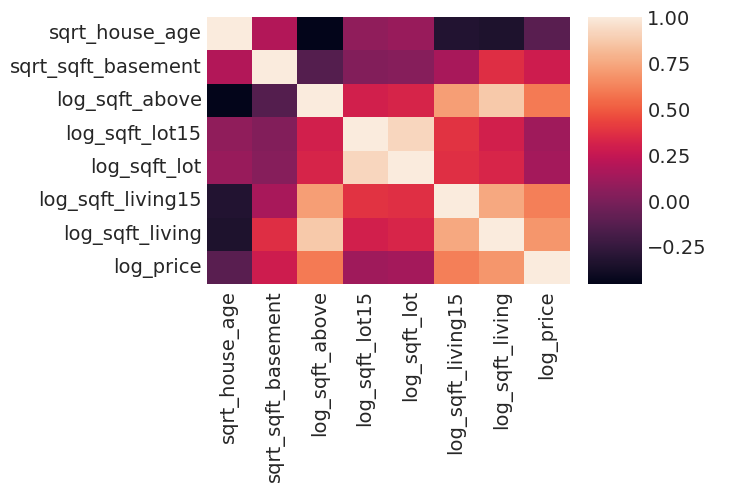

In [18]:
sns.heatmap(df_train.select_dtypes("float").iloc[::-1, ::-1].corr());

## Interactions
* remove date and zip code
* `log_price`- dependent variable

In [19]:
df_train.columns.difference(set(['zipcode', 'date', 'log_price'])).shape

(15,)

In [20]:
patsy_expr = f"log_price ~ ({' + '.join(df_train.columns.difference(set(['zipcode', 'date', 'log_price'])))}) ** 2"
# remove intercept
# patsy_expr = f"log_price ~ ({' + '.join(df_train.columns.difference(set(['zipcode', 'date', 'log_price'])))}) ** 2 - 1"
patsy_expr


'log_price ~ (grouped_bathrooms + grouped_bedrooms + grouped_condition + grouped_floors + grouped_grade + has_basement + has_view + log_sqft_above + log_sqft_living + log_sqft_living15 + log_sqft_lot + log_sqft_lot15 + sqrt_house_age + sqrt_sqft_basement + view) ** 2'

In [21]:
y_train, X_train = dmatrices(patsy_expr, data=df_train, return_type="dataframe")

In [22]:
X_train  # 15 features + (15 \choose 2) = 105 interaction features + intercept (1) -> 121 features

Intercept  grouped_bathrooms  grouped_bedrooms  grouped_condition  \
0            1.0                0.0               1.0                1.0   
1            1.0                2.0               1.0                1.0   
2            1.0                0.0               0.0                1.0   
3            1.0                2.0               2.0                3.0   
4            1.0                1.0               1.0                1.0   
...          ...                ...               ...                ...   
21608        1.0                2.0               1.0                1.0   
21609        1.0                2.0               2.0                1.0   
21610        1.0                0.0               0.0                1.0   
21611        1.0                2.0               1.0                1.0   
21612        1.0                0.0               0.0                1.0   

       grouped_floors  grouped_grade  has_basement  has_view  log_sqft_above  \
0                 0.0            2.0           0.0       0.0        7.073270   
1                 2.0            2.0           1.0       0.0        7.682482   
2                 0.0            1.0           0.0       0.0        6.646391   
3                 0.0            2.0           1.0       0.0        6.956545   
4                 0.0            3.0           0.0       0.0        7.426549   
...               ...            ...           ...       ...             ...   
21608             3.0            3.0           0.0       0.0        7.333023   
21609             2.0            3.0           0.0       0.0        7.745003   
21610             2.0            2.0           0.0       0.0        6.927558   
21611             2.0            3.0           0.0       0.0        7.377759   
21612             2.0            2.0           0.0       0.0        6.927558   

       log_sqft_living  ...  log_sqft_lot:log_sqft_lot15  \
0             7.073270  ...                    74.639419   
1             7.851661  ...                    79.464698   
2             6.646391  ...                    82.846247   
3             7.580700  ...                    72.542580   
4             7.426549  ...                    80.282068   
...                ...  ...                          ...   
21608         7.333023  ...                    51.460269   
21609         7.745003  ...                    76.986443   
21610         6.927558  ...                    54.811423   
21611         7.377759  ...                    55.692532   
21612         6.927558  ...                    50.354215   

       log_sqft_lot:sqrt_house_age  log_sqft_lot:sqrt_sqft_basement  \
0                        66.920588                         0.000000   
1                        71.101222                       177.753054   
2                        83.403179                         0.000000   
3                        60.225651                       256.931407   
4                        47.608428                         0.000000   
...                            ...                              ...   
21608                    17.222013                         0.000000   
21609                     8.667852                         0.000000   
21610                    17.655579                         0.000000   
21611                    25.797409                         0.000000   
21612                    18.470005                         0.000000   

       log_sqft_lot:view  log_sqft_lot15:sqrt_house_age  \
0                    0.0                      66.920588   
1                    0.0                      71.528176   
2                    0.0                      81.452437   
3                    0.0                      60.225651   
4                    0.0                      47.216386   
...                  ...                            ...   
21608                0.0                      17.928311   
21609                0.0                       8.881836   
21610                0.0    

# Feature Selection

## OLS statistics

In [21]:
class OLSFeatureSelection(TransformerMixin):
    
    _ITERATIONS: int=5
    
    def __init__(self, p_value: float=0.05, n_iterations: int=-1):
        self.p_value = p_value
        self.n_iterations = n_iterations
        self._features : pd.Index
        self._pct_significant_coeff : float
        
    @property
    def features(self):
        return self._features
    
    @property
    def pct_significant_coeff(self):
        return self._pct_significant_coeff
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]=None):
        self._ols_feature_selection(X=X, y=y)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = X.copy()
        return X[self.features]
        
    def _ols_feature_selection(self, X: pd.DataFrame, y: pd.Series):
        features = X.columns
        n_iterations = self.n_iterations if self.n_iterations > 0 else OLSFeatureSelection._ITERATIONS
        p_values_mask = None
        for _ in range(n_iterations):
            model = sm.OLS(y, X[features])
            results = model.fit()
            p_values_mask = results.pvalues < self.p_value
            features = results.pvalues[p_values_mask].index
            
        self._features = features
        self._pct_significant_coeff = (p_values_mask).mean()
        
                
            

In [22]:
ols_fs = OLSFeatureSelection()

In [23]:
X_train_ols = ols_fs.fit_transform(X=X_train, y=y_train)
X_train_ols.shape

(17356, 38)

In [24]:
ols_fs.features

Index(['grouped_bathrooms', 'grouped_bedrooms', 'grouped_condition',
       'grouped_floors', 'log_sqft_living', 'log_sqft_living15',
       'log_sqft_lot', 'sqrt_house_age', 'view',
       'grouped_bathrooms:grouped_floors', 'grouped_bathrooms:log_sqft_living',
       'grouped_bathrooms:sqrt_house_age', 'grouped_bedrooms:grouped_floors',
       'grouped_bedrooms:log_sqft_living15', 'grouped_bedrooms:sqrt_house_age',
       'grouped_bedrooms:view', 'grouped_condition:log_sqft_living15',
       'grouped_condition:log_sqft_lot15', 'grouped_condition:sqrt_house_age',
       'grouped_floors:grouped_grade', 'grouped_floors:has_basement',
       'grouped_floors:log_sqft_living15', 'grouped_floors:log_sqft_lot',
       'grouped_floors:log_sqft_lot15', 'grouped_floors:sqrt_house_age',
       'grouped_grade:log_sqft_lot', 'has_basement:log_sqft_above',
       'has_basement:log_sqft_living', 'has_basement:sqrt_house_age',
       'has_view:view', 'log_sqft_above:log_sqft_living15',
       'log_sq

In [ ]:
# ols_model = sm.OLS(y_train, X_train)
# results = ols_model.fit()
# results.summary()

## MRMR (minimum redundancy maximum relevance)
* an iterative process of selecting the next most significant feature, given that |S| features have already been selected
* $\text{MRMR} = \frac{\max_i \text{corr}(x_i, y)}{\min_{i:i \notin S}\text{corr}(x_i, x_S)}$
    * $X_S$- |S| set of features with the highest MRMR score

In [25]:
class MRMR(TransformerMixin):
    def __init__(self, num_features: Optional[int]=None, feature_list: Optional[List[str]]=None):
        self.num_features = num_features  # take best num_features based on MRMR score
        self.feature_list = feature_list
        self._features :List[str]=[]
        self._feature_scores: pd.DataFrame
            
    
    @property
    def features(self) -> List[str]:
        return self._features
    
    @property
    def feature_scores(self) -> pd.DataFrame:
        return self._feature_scores
    
    def mrmr_score(self) -> float:
        return self.feature_scores['score'].sum()
    
    def mrmr_plot(self, num_features: Optional[int]=None):
        top_k_features = num_features if num_features is not None else self.num_features
        df_scores = self.feature_scores.loc[self.feature_scores['rank'] <= top_k_features].copy()
        df_scores["cumulative score"] = df_scores["score"].cumsum()
        df_scores.plot(x="feature", y="cumulative score", rot=90, legend=False, title="Cumulative MRMR");
        
    
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]=None):
        self._mrmr(X=X, y=y)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = X.copy()
        return X[self.features[:self.num_features]] if self.num_features is not None else X
    
    
    def _mrmr(self, X: pd.DataFrame, y: pd.Series):
        features = self.feature_list if self.feature_list is not None else X.columns
        df_corr = (
            pd.concat([X[features], y], axis=1)
                .corr()
                .abs()
        )  # abs- we care about magnitude not about direction
        num_corr = df_corr.iloc[:-1, -1]
        features_corr = df_corr.iloc[:-1, :-1]
        
        mrmr_scores = []
#         first feature- highest correlation with dependent variable
        mrmr_features = []
        mrmr_features.append(num_corr.idxmax())  
        mrmr_scores.append(num_corr.max())
        while len(mrmr_features) < len(features):
            cand_features = sorted(set(features).difference(set(mrmr_features)))
            cand_num = num_corr.loc[cand_features]
            cand_denum = (features_corr.loc[mrmr_features, cand_features].max() 
                          if isinstance(features_corr.loc[mrmr_features, cand_features], pd.DataFrame)
                          else features_corr.loc[mrmr_features, cand_features])
            scores = cand_num / cand_denum
            
            mrmr_scores.append(scores.max())
            mrmr_features.append(scores.idxmax())
        
#         self._feature_scores = pd.Series(np.array(mrmr_scores), index=self._features)
        self._features = mrmr_features
        self._feature_scores = pd.DataFrame(zip(range(1, len(mrmr_features) + 1), mrmr_features, mrmr_scores),
                                           columns=["rank", "feature", "score"])

## SHAP values
* Explainer object- use it to evaluate a sample or the full dataset
    * `.data`- a copy of the input data
    * `.base_values`- the expected value of the target
    * `.values`- the SHAP values for each example
    * `shap_values()`-  the SHAP values

In [33]:
class SHAP(TransformerMixin):
    def __init__(self, model: BaseEstimator, num_features: Optional[int]=None, feature_list: Optional[List[str]]=None):
        self.model = model
        self.num_features = num_features  # take best num_features based on MRMR score
        self.feature_list = feature_list
        self._features :List[str]=[]
        self._feature_scores: pd.DataFrame
            
    
    @property
    def features(self) -> List[str]:
        return self._features
    
    @property
    def feature_scores(self) -> pd.DataFrame:
        return self._feature_scores
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]=None):
        self._shap_values(X=X, y=y)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = X.copy()
        return X[self.features[:self.num_features]] if self.num_features is not None else X
    
    
    def _shap_values(self, X: pd.DataFrame, y: pd.Series):
        features = self.feature_list if self.feature_list is not None else X.columns
        self.model.fit(X[features], y)
        expainer = shap.Explainer(self.model.predict, X[features])
        instances_shap_values = expainer(X[features]).values
        shap_values = np.mean(np.abs(instances_shap_values), axis=0)
        normalized_shap_values = softmax(shap_values)
        feature_idxes = np.argsort(normalized_shap_values)[::-1]
        self._features = np.array(features)[feature_idxes]
        self._feature_scores = pd.DataFrame(
            zip(range(1, len(self._features) + 1), self._features, normalized_shap_values[feature_idxes]),
            columns=["rank", "feature", "score"]
        )


## K-fold Feature Selection

In [34]:
class KFoldFeatureSelection:
    def __init__(self, feature_selector: Union[MRMR, SHAP], n_splits: int=10):
        self.n_splits = n_splits
        self._kf = KFold(n_splits=self.n_splits)
        self._feature_selector = feature_selector
        self._df_features: pd.DataFrame
        
    @property
    def df_features(self) -> pd.DataFrame:
        return self._df_features
    
    def get_feature_scores(self, n) -> pd.DataFrame:
        return (self.df_features
                    .groupby(["rank", "feature"])['score'].mean()
                    .reset_index(level=0)
                    .groupby("rank")["score"].nlargest(n=n)
                    .reset_index()
               )
    
    def create_feature_scores(self, X: pd.DataFrame, y: pd.Series):
        feature_scores = []
        for train_idx, _ in tqdm(self._kf.split(X), total=self.n_splits):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#             X_val, y_val = X[val_index], y[val_index]
            self._feature_selector.fit(X_train, y_train)
            feature_scores.append(self._feature_selector.feature_scores)
        self.feature_scores = feature_scores
        self._df_features = pd.concat(feature_scores, axis=0)
        

In [80]:
shap_feature_selector = SHAP(model=LinearRegression())

In [81]:
shap_feature_selector.fit(X_train.iloc[:200,:], y_train.iloc[:200])

Permutation explainer: 201it [00:19,  5.05it/s]                                                                        


In [82]:
shap_feature_selector.feature_scores

rank                            feature     score
0       1       has_basement:log_sqft_living  0.089970
1       2        has_basement:log_sqft_above  0.088175
2       3   log_sqft_above:log_sqft_living15  0.014789
3       4       grouped_grade:log_sqft_above  0.012840
4       5     log_sqft_living:sqrt_house_age  0.012725
..    ...                                ...       ...
116   117             grouped_grade:has_view  0.005304
117   118         grouped_condition:has_view  0.005302
118   119     grouped_bathrooms:has_basement  0.005303
119   120  grouped_floors:sqrt_sqft_basement  0.005300
120   121                          Intercept  0.005297

[121 rows x 3 columns]

In [132]:
mrmr_feature_selector = MRMR()

In [84]:
mrmr_feature_selector.fit(X_train, y_train)

In [85]:
mrmr_feature_selector.feature_scores

rank                            feature     score
0       1      grouped_grade:log_sqft_living  0.725773
1       2     grouped_condition:has_basement  7.926953
2       3                sqrt_house_age:view  1.627184
3       4   grouped_bathrooms:sqrt_house_age  1.146344
4       5  grouped_floors:sqrt_sqft_basement  1.108115
..    ...                                ...       ...
116   117                  grouped_condition  0.041981
117   118      log_sqft_above:sqrt_house_age  0.038507
118   119     log_sqft_living:sqrt_house_age  0.023089
119   120   grouped_condition:sqrt_house_age  0.001252
120   121                                NaN       NaN

[121 rows x 3 columns]

In [35]:
shap_ols_fs = SHAP(model=LinearRegression())
shap_ridge_fs = SHAP(model=Ridge())
shap_lasso_fs = SHAP(model=Lasso())
mrmr_fs = MRMR()

In [2]:
k_fold_ols_fs = KFoldFeatureSelection(
    feature_selector=shap_ols_fs)  # n_splits=10

k_fold_ols_fs.create_feature_scores(X_train, y_train)
ols_scores = k_fold_ols_fs.get_feature_scores(n=5)
ols_scores.to_csv('ols_feature_selection.csv', index=False)

In [3]:
k_fold_ridge_fs = KFoldFeatureSelection(
    feature_selector=shap_ridge_fs)

k_fold_ridge_fs.create_feature_scores(X_train, y_train)
ridge_scores = k_fold_ridge_fs.get_feature_scores(n=5)
ridge_scores.to_csv('ridge_feature_selection.csv', index=False)

In [ ]:
k_fold_lasso_fs = KFoldFeatureSelection(
    feature_selector=shap_lasso_fs)

k_fold_lasso_fs.create_feature_scores(X_train, y_train)
lasso_scores = k_fold_lasso_fs.get_feature_scores(n=5)
lasso_scores.to_csv('lasso_feature_selection.csv', index=False)

In [38]:
k_fold_mrmr_fs = KFoldFeatureSelection(
    feature_selector=mrmr_fs
)

k_fold_mrmr_fs.create_feature_scores(X_train, y_train)
mrmr_scores = k_fold_mrmr_fs.get_feature_scores(n=5)
mrmr_scores.to_csv('mrmr_feature_selection.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [158]:
k_fold_mrmr_fs.feature_scores[0]

rank                            feature     score
0       1      grouped_grade:log_sqft_living  0.728146
1       2     grouped_condition:has_basement  7.097761
2       3                sqrt_house_age:view  1.588097
3       4   grouped_bathrooms:sqrt_house_age  1.157213
4       5  grouped_floors:sqrt_sqft_basement  1.105311
..    ...                                ...       ...
115   116   grouped_condition:log_sqft_lot15  0.056476
116   117      log_sqft_above:sqrt_house_age  0.042458
117   118                  grouped_condition  0.040107
118   119     log_sqft_living:sqrt_house_age  0.027072
119   120   grouped_condition:sqrt_house_age  0.002665

[120 rows x 3 columns]

In [160]:
k_fold_mrmr_fs.df_features

rank                            feature     score
0       1      grouped_grade:log_sqft_living  0.728146
1       2     grouped_condition:has_basement  7.097761
2       3                sqrt_house_age:view  1.588097
3       4   grouped_bathrooms:sqrt_house_age  1.157213
4       5  grouped_floors:sqrt_sqft_basement  1.105311
..    ...                                ...       ...
115   116                  grouped_condition  0.059931
116   117   grouped_condition:sqrt_house_age  0.032537
117   118     log_sqft_living:sqrt_house_age  0.021788
118   119   log_sqft_living15:sqrt_house_age  0.015776
119   120      log_sqft_above:sqrt_house_age  0.003098

[1200 rows x 3 columns]

In [136]:
k_fold_mrmr_fs.df_features#.nunique()

rank                            feature     score
0      1      grouped_grade:log_sqft_living  0.728146
1      2     grouped_condition:has_basement  7.097761
2      3                sqrt_house_age:view  1.588097
3      4   grouped_bathrooms:sqrt_house_age  1.157213
4      5  grouped_floors:sqrt_sqft_basement  1.105311
..   ...                                ...       ...
0      1      grouped_grade:log_sqft_living  0.727128
0      1      grouped_grade:log_sqft_living  0.725265
0      1      grouped_grade:log_sqft_living  0.725726
0      1      grouped_grade:log_sqft_living  0.727125
0      1      grouped_grade:log_sqft_living  0.718283

[129 rows x 3 columns]

# Models
* `statsmodels`- OLS
* `sklearn`- OLS, LASSO, Ridge
* zipcode- one-hot encoding
* `PyMC`- pooling, unpooling, hierarchical

* **Evaluation**- RMSE, MAE, $\mathcal{r}^2$

In [47]:
def evaluation(y_true: pd.Series, y_pred: pd.Series, *metrics) -> List[str]:
    return [metric(y_true, y_pred) for metric in metrics]

In [ ]:
# TODO: set features + one-hot encoding (zipcode)

In [20]:
features = ['grouped_bathrooms:log_sqft_living',
            'grouped_grade:log_sqft_above',
            'grouped_floors:log_sqft_living',
            'has_basement:log_sqft_above',
            'log_sqft_above:log_sqft_living',
            'has_view:log_sqft_above',
            'grouped_bedrooms:log_sqft_living',
            'grouped_bedrooms:grouped_condition',
            'grouped_floors:sqrt_house_age',
            'has_basement:log_sqft_living',
            'grouped_condition:grouped_grade',
            'grouped_bedrooms:grouped_grade',
            'grouped_condition',
            'has_view',
            'grouped_condition:has_basement',
            'grouped_bedrooms',
            'grouped_grade',
            'grouped_bathrooms:grouped_grade',
            'grouped_floors:log_sqft_above',
            'has_basement',
            'view',
            'sqrt_house_age',
            'log_sqft_above:log_sqft_lot15',
            'log_sqft_above:log_sqft_living15',
            'log_sqft_living15:sqrt_house_age',
            'grouped_grade:log_sqft_living15',
            'grouped_floors',
            'log_sqft_above:sqrt_sqft_basement',
            'grouped_bathrooms:sqrt_house_age',
            'grouped_condition:grouped_floors',
            'log_sqft_living:sqrt_house_age',
            'log_sqft_living:log_sqft_living15',
            'log_sqft_living15',
            'grouped_floors:sqrt_sqft_basement',
            'has_basement:sqrt_house_age',
            'log_sqft_living',
            'log_sqft_above',
            'grouped_bathrooms',
            'log_sqft_above:sqrt_house_age',
            'grouped_grade:log_sqft_living',
            'log_sqft_living:view',
            'log_sqft_above:view',
            'log_sqft_lot15',
            'sqrt_sqft_basement',
            'grouped_grade:sqrt_house_age',
            'has_view:log_sqft_living']

In [21]:
features_with_intercept = ["Intercept"] + features

## Linear Regression Models
* OLS, Ridge and Lasso

In [40]:
patsy_expr = f"log_price ~ ({' + '.join(df_train.columns.difference(set(['zipcode', 'date', 'log_price'])))}) ** 2"
y_train, X_train = dmatrices(patsy_expr, data=df_train, return_type="dataframe")

In [41]:
y_test, X_test = dmatrices(patsy_expr, data=df_test, return_type="dataframe")

In [29]:
# handpicked features based on MRMR and SHAP values + one-hot encoding representation for zipcode
X_train_ols = pd.concat(
    [X_train[features_with_intercept], pd.get_dummies(data=df_train['zipcode'], prefix='zipcode', drop_first=True)],
    axis=1)

X_train_reg = pd.concat(
    [X_train[features], pd.get_dummies(data=df_train['zipcode'], prefix='zipcode', drop_first=True)],
    axis=1)

X_train_ols.shape, X_train_reg.shape

((17356, 116), (17356, 115))

In [30]:
X_test_ols = pd.concat(
    [X_test[features_with_intercept], pd.get_dummies(data=df_test['zipcode'], prefix='zipcode', drop_first=True)],
    axis=1)

X_test_reg = pd.concat(
    [X_test[features], pd.get_dummies(data=df_test['zipcode'], prefix='zipcode', drop_first=True)],
    axis=1)

X_test_ols.shape, X_test_reg.shape

((4257, 116), (4257, 115))

In [31]:
model = sm.OLS(y_train, X_train_ols)
ols = model.fit()
ols.summary()
# prediction (test set)
y_pred_ols = ols.predict(X_test_ols)

In [32]:
model = LinearRegression()
model.fit(X_train_reg, y_train)
y_pred_lin_reg = model.predict(X_test_reg)

In [33]:
model = Ridge()
model.fit(X_train_reg, y_train)
y_pred_ridge = model.predict(X_test_reg)

In [34]:
model = Lasso()
model.fit(X_train_reg, y_train)
y_pred_lasso = model.predict(X_test_reg)

In [35]:
y_pred_lin_reg

array([[12.62038202],
       [12.67062586],
       [13.48190711],
       ...,
       [14.05897035],
       [12.81828679],
       [13.68963039]])

In [64]:
y_pred_ridge

array([[12.62202786],
       [12.66838616],
       [13.475777  ],
       ...,
       [14.05173358],
       [12.82152877],
       [13.68326433]])

In [63]:
y_pred_lasso

array([13.00983871, 12.81566811, 13.39483628, ..., 13.50157374,
       12.99521974, 13.53569231])

In [59]:
y_pred_ols

8        12.620382
9        12.670626
10       13.481907
14       13.194674
19       12.288886
           ...    
21592    12.977248
21593    13.719845
21597    14.058970
21601    12.818287
21606    13.689630
Length: 4257, dtype: float64

In [36]:
mean_squared_error = partial(mean_squared_error,  squared=False)

eval_table = []
y_preds = [y_pred_ols, y_pred_lin_reg, y_pred_ridge, y_pred_lasso]
model_names = ["OLS (statsmoels)", "OLS", "Ridge", "Lasso"]
for model_name, y_pred in zip(model_names, y_preds):
    eval_row = [model_name, *evaluation(np.exp(y_test), np.exp(y_pred), mean_absolute_error, mean_squared_error, r2_score)]
    eval_table.append(eval_row)
    


In [37]:
df_eval = pd.DataFrame(eval_table, columns=["model", "MAE", "RMSE", r"$R^2$"])
df_eval

model            MAE           RMSE     $R^2$
0  OLS (statsmoels)   85746.831334  155077.242132  0.822943
1               OLS   85746.831334  155077.242132  0.822943
2             Ridge   86091.979736  155664.747791  0.821599
3             Lasso  167496.552737  280228.190768  0.421851

## Bayesian Regression Models

### Pooled Model
* a single model for the entire data





#### Normal β's
* L2 regularization

In [76]:
df_train.dtypes

view                    int64
zipcode                 int64
log_price             float64
grouped_bedrooms         int8
grouped_bathrooms        int8
grouped_floors           int8
grouped_grade            int8
grouped_condition        int8
has_view                int32
has_basement            int32
log_sqft_living       float64
log_sqft_living15     float64
log_sqft_lot          float64
log_sqft_lot15        float64
log_sqft_above        float64
sqrt_sqft_basement    float64
sqrt_house_age        float64
dtype: object

In [75]:
df_train.head()
# df_train.shape

view  zipcode  log_price  grouped_bedrooms  grouped_bathrooms  \
0     0    98178  12.309982                 1                  0   
1     0    98125  13.195614                 1                  2   
2     0    98028  12.100712                 0                  0   
3     0    98136  13.311329                 2                  2   
4     0    98074  13.142166                 1                  1   

   grouped_floors  grouped_grade  grouped_condition  has_view  has_basement  \
0               0              2                  1         0             0   
1               2              2                  1         0             1   
2               0              1                  1         0             0   
3               0              2                  3         0             1   
4               0              3                  1         0             0   

   log_sqft_living  log_sqft_living15  log_sqft_lot  log_sqft_lot15  \
0         7.073270           7.200425      8.639411        8.639411   
1         7.851661           7.432484      8.887653        8.941022   
2         6.646391           7.908387      9.210340        8.994917   
3         7.580700           7.215240      8.517193        8.517193   
4         7.426549           7.495542      8.997147        8.923058   

   log_sqft_above  sqrt_sqft_basement  sqrt_house_age  
0        7.073270            0.000000        7.745967  
1        7.682482           20.000000        8.000000  
2        6.646391            0.000000        9.055385  
3        6.956545           30.166206        7.071068  
4        7.426549            0.000000        5.291503

In [79]:
df_train.select_dtypes(["int", "int8"]).drop("zipcode", axis=1)

view  grouped_bedrooms  grouped_bathrooms  grouped_floors  \
0         0                 1                  0               0   
1         0                 1                  2               2   
2         0                 0                  0               0   
3         0                 2                  2               0   
4         0                 1                  1               0   
...     ...               ...                ...             ...   
21608     0                 1                  2               3   
21609     0                 2                  2               2   
21610     0                 0                  0               2   
21611     0                 1                  2               2   
21612     0                 0                  0               2   

       grouped_grade  grouped_condition  has_view  has_basement  
0                  2                  1         0             0  
1                  2                  1         0             1  
2                  1                  1         0             0  
3                  2                  3         0             1  
4                  3                  1         0             0  
...              ...                ...       ...           ...  
21608              3                  1         0             0  
21609              3                  1         0             0  
21610              2                  1         0             0  
21611              3                  1         0             0  
21612              2                  1         0             0  

[17356 rows x 8 columns]

In [38]:
RANDOM_SEED = 8296

mu_beta = 0
sd_beta = 2.0
sd_eps = 1.0
n_features = 15

In [22]:
df_train.columns

Index(['view', 'zipcode', 'log_price', 'grouped_bedrooms', 'grouped_bathrooms',
       'grouped_floors', 'grouped_grade', 'grouped_condition', 'has_view',
       'has_basement', 'log_sqft_living', 'log_sqft_living15', 'log_sqft_lot',
       'log_sqft_lot15', 'log_sqft_above', 'sqrt_sqft_basement',
       'sqrt_house_age'],
      dtype='object')

In [45]:
features_name = ["view", "grouped_bedrooms", "grouped_bathrooms", "grouped_floors", "grouped_grade",
            "grouped_condition", "has_view", "has_basement", "log_sqft_living", "log_sqft_living15",
            "log_sqft_lot", "log_sqft_lot15", "log_sqft_above", "sqrt_sqft_basement", "sqrt_house_age"]
POOLED_COORDS = {"slopes": features_name}

In [49]:
with pm.Model(coords=POOLED_COORDS) as pooled_l2_model:
    view = pm.MutableData("view", X_train['view'].values)
    grouped_bedrooms = pm.MutableData("grouped_bedrooms", X_train['grouped_bedrooms'].values)
    grouped_bathrooms = pm.MutableData("grouped_bathrooms", X_train['grouped_bathrooms'].values)
    grouped_floors = pm.MutableData("grouped_floors", X_train['grouped_floors'].values)
    grouped_grade = pm.MutableData("grouped_grade", X_train['grouped_grade'].values)
    grouped_condition = pm.MutableData("grouped_condition", X_train['grouped_condition'].values)
    has_view = pm.MutableData("has_view", X_train['has_view'].values)
    has_basement = pm.MutableData("has_basement", X_train['has_basement'].values)
    log_sqft_living = pm.MutableData("log_sqft_living", X_train['log_sqft_living'].values)
    log_sqft_living15 = pm.MutableData("log_sqft_living15", X_train['log_sqft_living15'].values)
    log_sqft_lot = pm.MutableData("log_sqft_lot", X_train['log_sqft_lot'].values)
    log_sqft_lot15 = pm.MutableData("log_sqft_lot15", X_train['log_sqft_lot15'].values)
    log_sqft_above = pm.MutableData("log_sqft_above", X_train['log_sqft_above'].values)
    sqrt_sqft_basement = pm.MutableData("sqrt_sqft_basement", X_train['sqrt_sqft_basement'].values)
    sqrt_house_age = pm.MutableData("sqrt_house_age", X_train['sqrt_house_age'].values)
    
    features = [view, grouped_bedrooms, grouped_bathrooms, grouped_floors, grouped_grade, grouped_condition, 
                has_view, has_basement, log_sqft_living, log_sqft_living15, log_sqft_lot, log_sqft_lot15,
                log_sqft_above, sqrt_sqft_basement, sqrt_house_age]
    
    log_price = pm.MutableData("log_price", y_train['log_price'].values)
#     priors
    intercept = pm.Normal("intercept")  # ~N(0, 1)
    β = pm.Normal('beta', mu=mu_beta, sigma=sd_beta, dims="slopes")  # try Laplace
    
#     observational noise
    ε = pm.HalfNormal("eps", sd_eps)
    
    
#     linear regression
    mu = ( intercept + sum(β[i] * feature for i, feature in enumerate(features)))
#     likelihood
    log_obs = pm.Normal("log_obs", mu=mu, sigma=ε, observed=log_price)
#     sampling
    idata_l2_pooled = pm.sample(random_seed=RANDOM_SEED)
    idata_l2_pooled.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata_l2_pooled.extend(pm.sample_posterior_predictive(idata_l2_pooled, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2311 seconds.


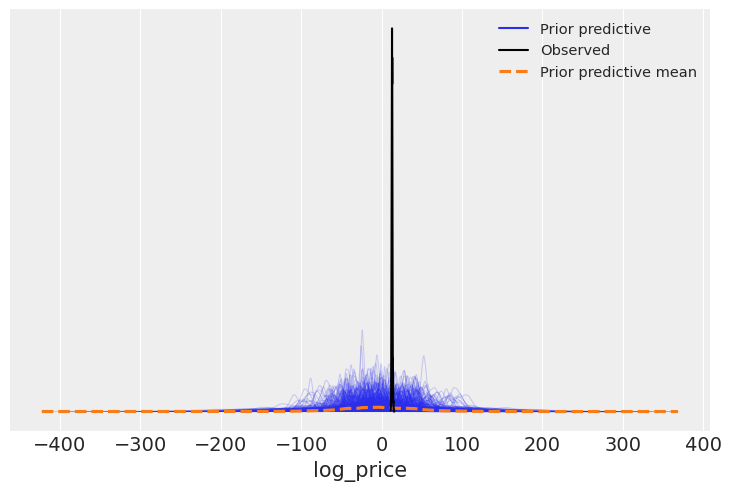

In [50]:
ax = az.plot_ppc(idata_l2_pooled, group="prior", observed=True)
ax.set_xlabel("log_price");

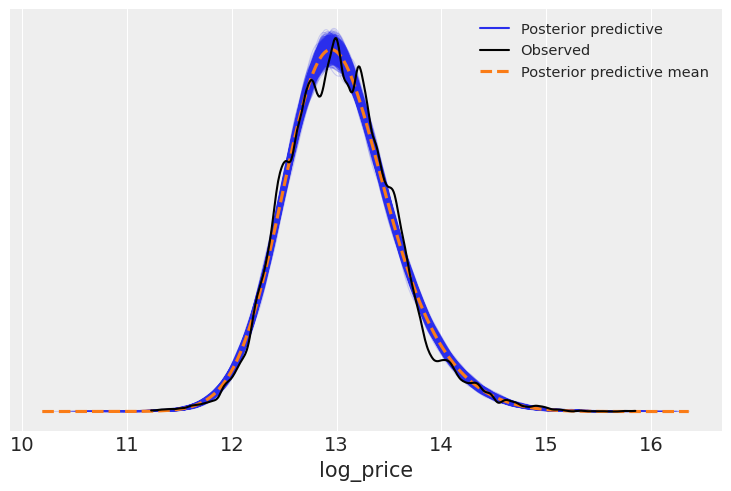

In [51]:
ax = az.plot_ppc(idata_l2_pooled)
ax.set_xlabel("log_price");

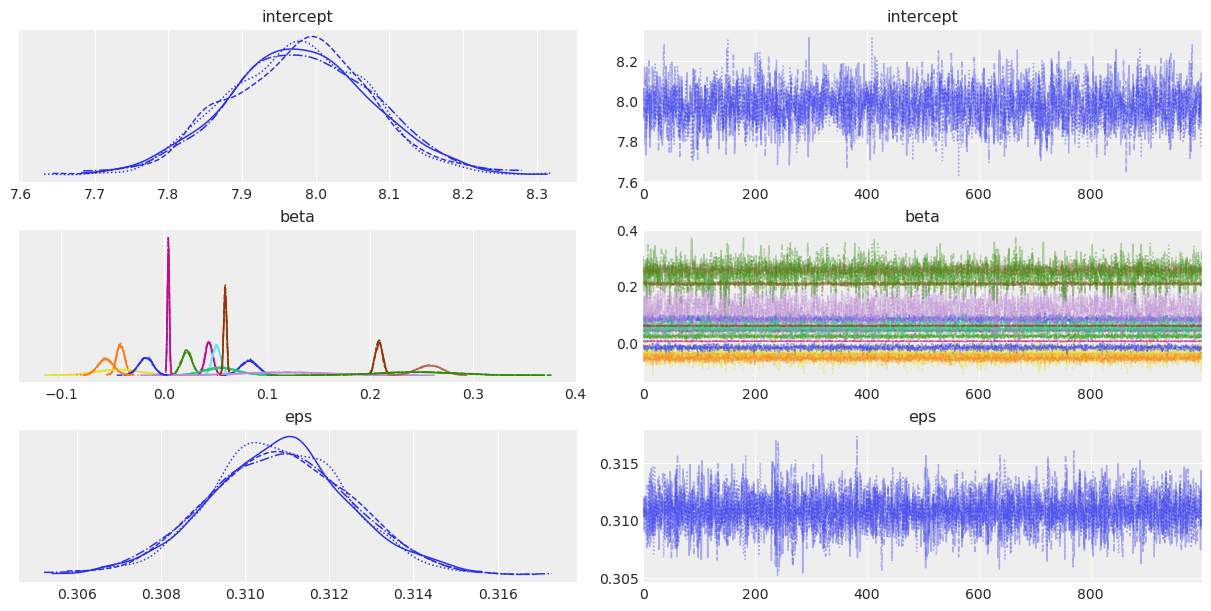

In [52]:
az.plot_trace(idata_l2_pooled);

In [55]:
with pooled_l2_model:
    pm.set_data(
        {
            "view": X_test['view'].values,
            "grouped_bedrooms": X_test['grouped_bedrooms'].values,
            "grouped_bathrooms": X_test['grouped_bathrooms'].values,
            "grouped_floors": X_test['grouped_floors'].values,
            "grouped_grade": X_test['grouped_grade'].values,
            "grouped_condition": X_test['grouped_condition'].values,
            "has_view": X_test['has_view'].values,
            "has_basement": X_test['has_basement'].values,
            "log_sqft_living": X_test['log_sqft_living'].values,
            "log_sqft_living15": X_test['log_sqft_living15'].values,
            "log_sqft_lot": X_test['log_sqft_lot'].values,
            "log_sqft_lot15": X_test['log_sqft_lot15'].values,
            "log_sqft_above": X_test['log_sqft_above'].values,
            "sqrt_sqft_basement": X_test['sqrt_sqft_basement'].values,
            "sqrt_house_age": X_test['sqrt_house_age'].values,
            "log_price": y_test['log_price'].values
        }
    )

In [56]:
with pooled_l2_model:
    idata_l2_pooled = pm.sample_posterior_predictive(
        idata_l2_pooled,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

In [95]:
pooled_preds = idata_l2_pooled.predictions["log_obs"].mean(dim=("chain", "draw")).data#["log_obs_dim_0"]

In [96]:
eval_row = ["pooled_l2_model", *evaluation(np.exp(y_test), np.exp(pooled_preds), mean_absolute_error, mean_squared_error, r2_score)]
eval_table.append(eval_row)


df_eval = pd.DataFrame(eval_table, columns=["model", "MAE", "RMSE", r"$R^2$"])
df_eval

model            MAE           RMSE     $R^2$
0  OLS (statsmoels)   85746.831334  155077.242132  0.822943
1               OLS   85746.831334  155077.242132  0.822943
2             Ridge   86091.979736  155664.747791  0.821599
3             Lasso  167496.552737  280228.190768  0.421851
4   pooled_l2_model  143504.115035  231115.391420  0.606745

#### Laplacian β's 
* L1 regularization (feature selection)

In [102]:
with pm.Model(coords=POOLED_COORDS) as pooled_l1_model:
    view = pm.MutableData("view", X_train['view'].values)
    grouped_bedrooms = pm.MutableData("grouped_bedrooms", X_train['grouped_bedrooms'].values)
    grouped_bathrooms = pm.MutableData("grouped_bathrooms", X_train['grouped_bathrooms'].values)
    grouped_floors = pm.MutableData("grouped_floors", X_train['grouped_floors'].values)
    grouped_grade = pm.MutableData("grouped_grade", X_train['grouped_grade'].values)
    grouped_condition = pm.MutableData("grouped_condition", X_train['grouped_condition'].values)
    has_view = pm.MutableData("has_view", X_train['has_view'].values)
    has_basement = pm.MutableData("has_basement", X_train['has_basement'].values)
    log_sqft_living = pm.MutableData("log_sqft_living", X_train['log_sqft_living'].values)
    log_sqft_living15 = pm.MutableData("log_sqft_living15", X_train['log_sqft_living15'].values)
    log_sqft_lot = pm.MutableData("log_sqft_lot", X_train['log_sqft_lot'].values)
    log_sqft_lot15 = pm.MutableData("log_sqft_lot15", X_train['log_sqft_lot15'].values)
    log_sqft_above = pm.MutableData("log_sqft_above", X_train['log_sqft_above'].values)
    sqrt_sqft_basement = pm.MutableData("sqrt_sqft_basement", X_train['sqrt_sqft_basement'].values)
    sqrt_house_age = pm.MutableData("sqrt_house_age", X_train['sqrt_house_age'].values)
    
    features = [view, grouped_bedrooms, grouped_bathrooms, grouped_floors, grouped_grade, grouped_condition, 
                has_view, has_basement, log_sqft_living, log_sqft_living15, log_sqft_lot, log_sqft_lot15,
                log_sqft_above, sqrt_sqft_basement, sqrt_house_age]
    
    log_price = pm.MutableData("log_price", y_train['log_price'].values)
#     priors
    intercept = pm.Normal("intercept")  # ~N(0, 1)
    β = pm.Laplace('beta', mu=mu_beta, b=sd_beta, dims="slopes")  # try Laplace
    
#     observational noise
    ε = pm.HalfNormal("eps", sd_eps)
    
#     linear regression
    mu = ( intercept + sum(β[i] * feature for i, feature in enumerate(features)))
#     likelihood
    log_obs = pm.Normal("log_obs", mu=mu, sigma=ε, observed=log_price)
#     sampling
    idata_l1_pooled = pm.sample(random_seed=RANDOM_SEED)
    idata_l1_pooled.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata_l1_pooled.extend(pm.sample_posterior_predictive(idata_l1_pooled, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2478 seconds.


Creating legend with loc="best" can be slow with large amounts of data.


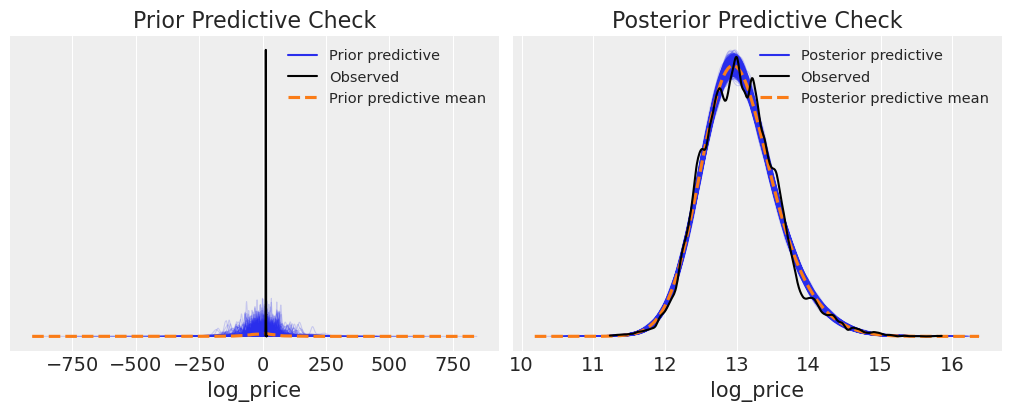

In [103]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
az.plot_ppc(idata_l1_pooled, group="prior", observed=True, ax=axes[0])
axes[0].set(xlabel="log_price", title="Prior Predictive Check");
az.plot_ppc(idata_l1_pooled, ax=axes[1])
axes[1].set(xlabel="log_price", title="Posterior Predictive Check");
plt.show()

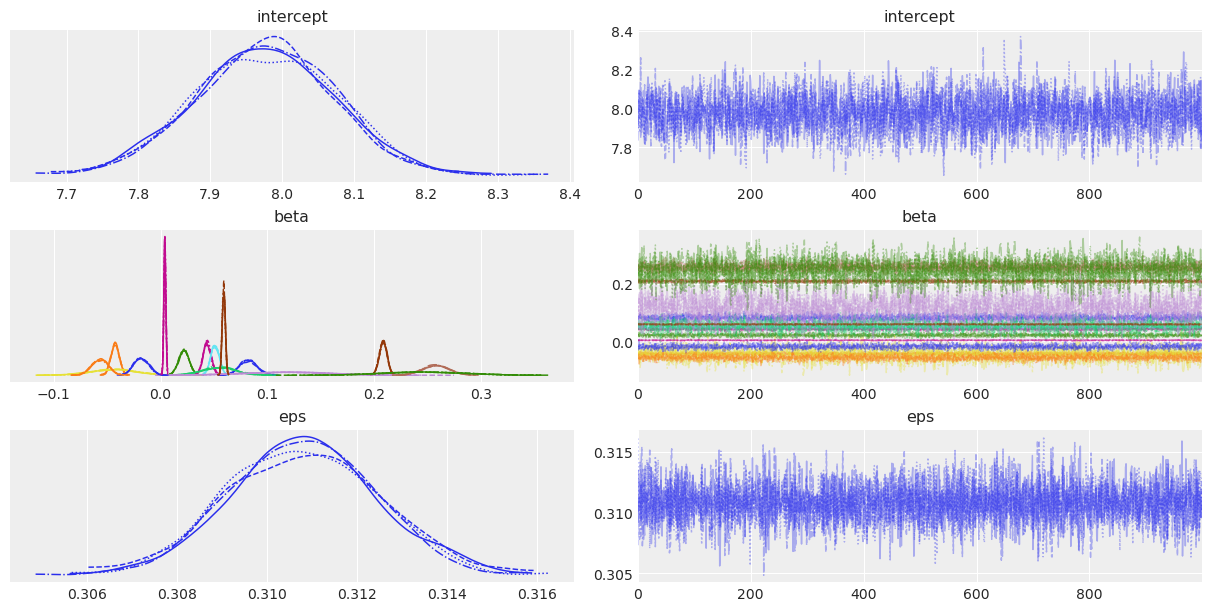

In [104]:
az.plot_trace(idata_l1_pooled);

In [110]:
az.summary(idata_l1_pooled, round_to=2)  # , kind="stats"

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                 7.98  0.10    7.80     8.15        0.0      0.0   
beta[view]                0.08  0.01    0.07     0.10        0.0      0.0   
beta[grouped_bedrooms]   -0.04  0.00   -0.05    -0.04        0.0      0.0   
beta[grouped_bathrooms]   0.02  0.00    0.01     0.03        0.0      0.0   
beta[grouped_floors]      0.04  0.00    0.04     0.05        0.0      0.0   
beta[grouped_grade]       0.21  0.00    0.20     0.22        0.0      0.0   
beta[grouped_condition]   0.05  0.00    0.04     0.06        0.0      0.0   
beta[has_view]           -0.04  0.02   -0.08    -0.01        0.0      0.0   
beta[has_basement]        0.05  0.02    0.02     0.08        0.0      0.0   
beta[log_sqft_living]     0.12  0.04    0.04     0.19        0.0      0.0   
beta[log_sqft_living15]   0.26  0.01    0.24     0.28        0.0      0.0   
beta[log_sqft_lot]       -0.02  0.01   -0.03    -0.01        0.0      0.0   
beta[log_sqft_lot15]     -0.06  0.01   -0.07    -0.04        0.0      0.0   
beta[log_sqft_above]      0.25  0.04    0.18     0.31        0.0      0.0   
beta[sqrt_sqft_basement]  0.00  0.00    0.00     0.01        0.0      0.0   
beta[sqrt_house_age]      0.06  0.00    0.06     0.06        0.0      0.0   
eps                       0.31  0.00    0.31     0.31        0.0      0.0   

                          ess_bulk  ess_tail  r_hat  
intercept                  2875.13   3137.25    1.0  
beta[view]                 3064.91   3035.53    1.0  
beta[grouped_bedrooms]     4781.73   3010.84    1.0  
beta[grouped_bathrooms]    4041.29   3065.34    1.0  
beta[grouped_floors]       5029.96   2616.58    1.0  
beta[grouped_grade]        4527.67   3226.85    1.0  
beta[grouped_condition]    5663.63   3058.99    1.0  
beta[has_view]             3042.24   2908.93    1.0  
beta[has_basement]         2981.05   2467.86    1.0  
beta[log_sqft_living]      1926.20   2449.43    1.0  
beta[log_sqft_living15]    3999.83   2716.32    1.0  
beta[log_sqft_lot]         3168.26   3226.51    1.0  
beta[log_sqft_lot15]       3214.98   2985.55    1.0  
beta[log_sqft_above]       2081.91   2943.03    1.0  
beta[sqrt_sqft_basement]   1784.49   2387.50    1.0  
beta[sqrt_house_age]       4909.55   3478.57    1.0  
eps                        6283.32   3171.67    1.0

In [111]:
with pooled_l1_model:
    pm.set_data(
        {
            "view": X_test['view'].values,
            "grouped_bedrooms": X_test['grouped_bedrooms'].values,
            "grouped_bathrooms": X_test['grouped_bathrooms'].values,
            "grouped_floors": X_test['grouped_floors'].values,
            "grouped_grade": X_test['grouped_grade'].values,
            "grouped_condition": X_test['grouped_condition'].values,
            "has_view": X_test['has_view'].values,
            "has_basement": X_test['has_basement'].values,
            "log_sqft_living": X_test['log_sqft_living'].values,
            "log_sqft_living15": X_test['log_sqft_living15'].values,
            "log_sqft_lot": X_test['log_sqft_lot'].values,
            "log_sqft_lot15": X_test['log_sqft_lot15'].values,
            "log_sqft_above": X_test['log_sqft_above'].values,
            "sqrt_sqft_basement": X_test['sqrt_sqft_basement'].values,
            "sqrt_house_age": X_test['sqrt_house_age'].values,
            "log_price": y_test['log_price'].values
        }
    )

In [112]:
with pooled_l1_model:
    idata_l1_pooled = pm.sample_posterior_predictive(
        idata_l1_pooled,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

In [113]:
pooled_l1_preds = idata_l1_pooled.predictions["log_obs"].mean(dim=("chain", "draw")).data#["log_obs_dim_0"]

In [114]:
eval_row = ["pooled_l1_model", *evaluation(np.exp(y_test), np.exp(pooled_l1_preds), mean_absolute_error, mean_squared_error, r2_score)]
eval_table.append(eval_row)

df_eval = pd.DataFrame(eval_table, columns=["model", "MAE", "RMSE", r"$R^2$"])
df_eval

model            MAE           RMSE     $R^2$
0  OLS (statsmoels)   85746.831334  155077.242132  0.822943
1               OLS   85746.831334  155077.242132  0.822943
2             Ridge   86091.979736  155664.747791  0.821599
3             Lasso  167496.552737  280228.190768  0.421851
4   pooled_l2_model  143504.115035  231115.391420  0.606745
5   pooled_l1_model  143500.440502  231112.360865  0.606756

## Unpooled Model
* fit a different regression model per category (zipcode)


In [115]:
zipcode_idx, zipcode = df_train["zipcode"].factorize(sort=True)

In [122]:
zipcode.shape, zipcode_idx.shape

((70,), (17356,))

In [127]:
features_name = ["view", "grouped_bedrooms", "grouped_bathrooms", "grouped_floors", "grouped_grade",
            "grouped_condition", "has_view", "has_basement", "log_sqft_living"
1
features_name = ["view", "grouped_bedrooms", "grouped_bathrooms", "grouped_floors", "grouped_grade",, "log_sqft_living15",
            "log_sqft_lot", "log_sqft_lot15", "log_sqft_above", "sqrt_sqft_basement", "sqrt_house_age"]


UNPOOLED_COORDS = {"slopes": features_name, "zipcode": zipcode}


In [130]:
with pm.Model(coords=UNPOOLED_COORDS) as unpooled_model:
    view = pm.MutableData("view", X_train['view'].values)
    grouped_bedrooms = pm.MutableData("grouped_bedrooms", X_train['grouped_bedrooms'].values)
    grouped_bathrooms = pm.MutableData("grouped_bathrooms", X_train['grouped_bathrooms'].values)
    grouped_floors = pm.MutableData("grouped_floors", X_train['grouped_floors'].values)
    grouped_grade = pm.MutableData("grouped_grade", X_train['grouped_grade'].values)
    grouped_condition = pm.MutableData("grouped_condition", X_train['grouped_condition'].values)
    has_view = pm.MutableData("has_view", X_train['has_view'].values)
    has_basement = pm.MutableData("has_basement", X_train['has_basement'].values)
    log_sqft_living = pm.MutableData("log_sqft_living", X_train['log_sqft_living'].values)
    log_sqft_living15 = pm.MutableData("log_sqft_living15", X_train['log_sqft_living15'].values)
    log_sqft_lot = pm.MutableData("log_sqft_lot", X_train['log_sqft_lot'].values)
    log_sqft_lot15 = pm.MutableData("log_sqft_lot15", X_train['log_sqft_lot15'].values)
    log_sqft_above = pm.MutableData("log_sqft_above", X_train['log_sqft_above'].values)
    sqrt_sqft_basement = pm.MutableData("sqrt_sqft_basement", X_train['sqrt_sqft_basement'].values)
    sqrt_house_age = pm.MutableData("sqrt_house_age", X_train['sqrt_house_age'].values)
    
    zipcode_idx_ = pm.MutableData("zipcode_idx", zipcode_idx)
    
    features = [view, grouped_bedrooms, grouped_bathrooms, grouped_floors, grouped_grade, grouped_condition, 
                has_view, has_basement, log_sqft_living, log_sqft_living15, log_sqft_lot, log_sqft_lot15,
                log_sqft_above, sqrt_sqft_basement, sqrt_house_age]
    
    log_price = pm.MutableData("log_price", y_train['log_price'].values)
#     priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="zipcode")  # ~N(0, 1)
    β = pm.Normal('beta', mu=mu_beta, sigma=sd_beta, dims=("zipcode", "slopes"))  # try Laplace
    
#     observational noise
    ε = pm.HalfNormal("eps", sd_eps)
    
    
#     linear regression
    mu = ( intercept[zipcode_idx_] + sum(β[zipcode_idx_, i] * feature for i, feature in enumerate(features)))
#     likelihood
    log_obs = pm.Normal("log_obs", mu=mu, sigma=ε, observed=log_price)
#     sampling
    idata_l2_unpooled = pm.sample(random_seed=RANDOM_SEED)
    idata_l2_unpooled.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata_l2_unpooled.extend(pm.sample_posterior_predictive(idata_l2_unpooled, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50128 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Creating legend with loc="best" can be slow with large amounts of data.


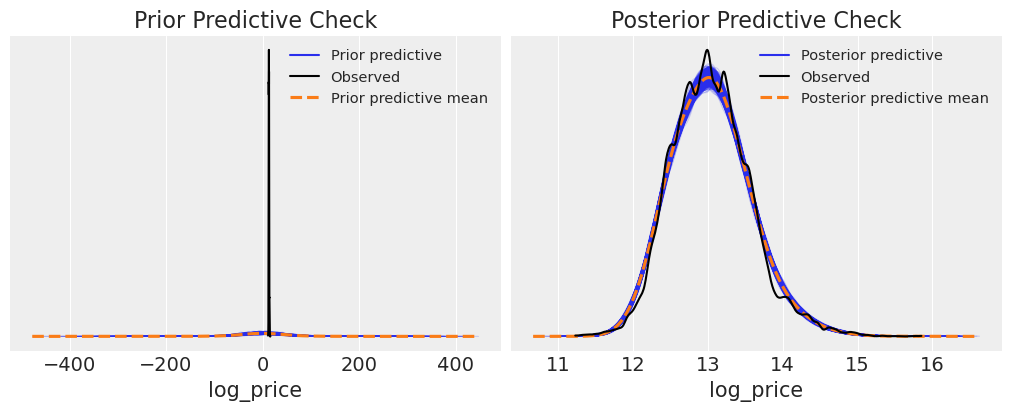

In [131]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
az.plot_ppc(idata_l2_unpooled, group="prior", observed=True, ax=axes[0])
axes[0].set(xlabel="log_price", title="Prior Predictive Check");
az.plot_ppc(idata_l2_unpooled, ax=axes[1])
axes[1].set(xlabel="log_price", title="Posterior Predictive Check");
plt.show()

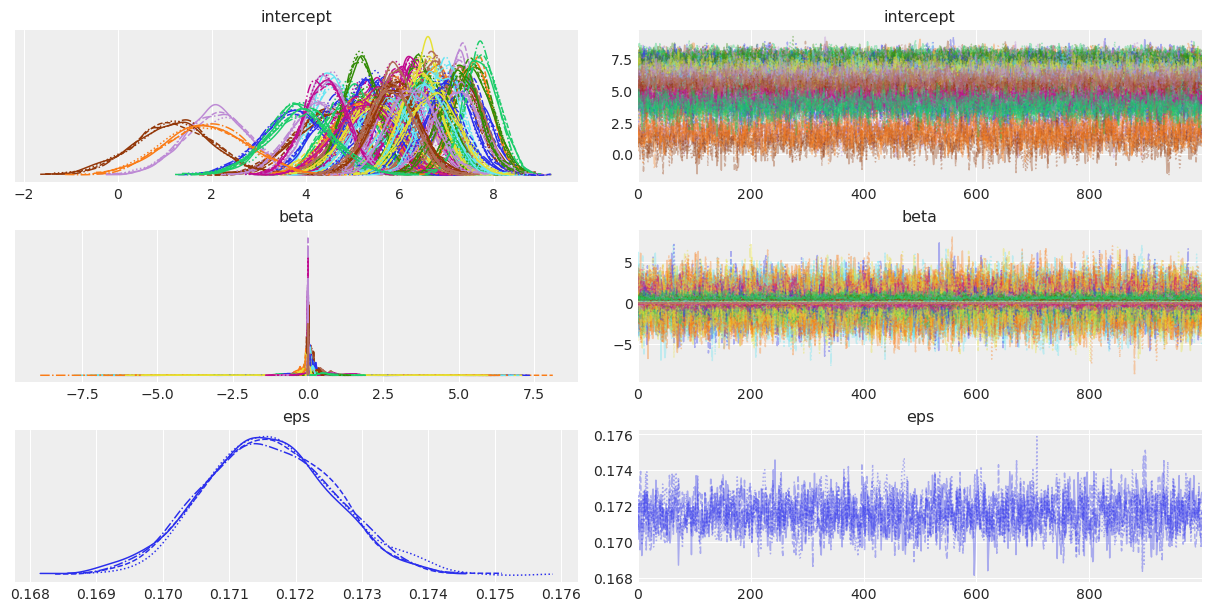

In [132]:
az.plot_trace(idata_l2_unpooled);

In [133]:
az.summary(idata_l2_unpooled, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  \
intercept[98001]                 5.64  0.48    4.75     6.55       0.02   
intercept[98002]                 5.42  0.63    4.27     6.64       0.02   
intercept[98003]                 5.31  0.54    4.29     6.35       0.02   
intercept[98004]                 5.30  0.46    4.49     6.20       0.01   
intercept[98005]                 4.47  0.69    3.22     5.81       0.02   
...                               ...   ...     ...      ...        ...   
beta[98199, log_sqft_lot15]      0.04  0.04   -0.03     0.11       0.00   
beta[98199, log_sqft_above]      0.53  0.16    0.24     0.83       0.01   
beta[98199, sqrt_sqft_basement]  0.00  0.00   -0.01     0.01       0.00   
beta[98199, sqrt_house_age]     -0.00  0.01   -0.02     0.01       0.00   
eps                              0.17  0.00    0.17     0.17       0.00   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
intercept[98001]                    0.01    946.41   1857.05   1.00  
intercept[98002]                    0.01   1047.03   1772.00   1.00  
intercept[98003]                    0.01    929.25   1520.01   1.00  
intercept[98004]                    0.01    974.84   1859.17   1.00  
intercept[98005]                    0.02   1037.61   1806.67   1.00  
...                                  ...       ...       ...    ...  
beta[98199, log_sqft_lot15]         0.00   1316.83   2155.31   1.00  
beta[98199, log_sqft_above]         0.01    438.38    876.57   1.01  
beta[98199, sqrt_sqft_basement]     0.00    406.93    776.97   1.01  
beta[98199, sqrt_house_age]         0.00   1056.82   1845.00   1.00  
eps                                 0.00   1470.47   2194.30   1.00  

[1121 rows x 9 columns]

In [138]:
with unpooled_model:
    pm.set_data(
        {
            "view": X_test['view'].values,
            "grouped_bedrooms": X_test['grouped_bedrooms'].values,
            "grouped_bathrooms": X_test['grouped_bathrooms'].values,
            "grouped_floors": X_test['grouped_floors'].values,
            "grouped_grade": X_test['grouped_grade'].values,
            "grouped_condition": X_test['grouped_condition'].values,
            "has_view": X_test['has_view'].values,
            "has_basement": X_test['has_basement'].values,
            "log_sqft_living": X_test['log_sqft_living'].values,
            "log_sqft_living15": X_test['log_sqft_living15'].values,
            "log_sqft_lot": X_test['log_sqft_lot'].values,
            "log_sqft_lot15": X_test['log_sqft_lot15'].values,
            "log_sqft_above": X_test['log_sqft_above'].values,
            "sqrt_sqft_basement": X_test['sqrt_sqft_basement'].values,
            "sqrt_house_age": X_test['sqrt_house_age'].values,
            "log_price": y_test['log_price'].values,
            
            "zipcode_idx": df_test["zipcode"].factorize(sort=True)[0]
        }
    )

In [139]:
with unpooled_model:
    idata_l2_unpooled = pm.sample_posterior_predictive(
        idata_l2_unpooled,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

In [140]:
unpooled_l2_preds = idata_l2_unpooled.predictions["log_obs"].mean(dim=("chain", "draw")).data

In [141]:
eval_row = ["unpooled_l2_model", *evaluation(np.exp(y_test), np.exp(unpooled_l2_preds), mean_absolute_error, mean_squared_error, r2_score)]
eval_table.append(eval_row)

df_eval = pd.DataFrame(eval_table, columns=["model", "MAE", "RMSE", r"$R^2$"])
df_eval

model            MAE           RMSE     $R^2$
0   OLS (statsmoels)   85746.831334  155077.242132  0.822943
1                OLS   85746.831334  155077.242132  0.822943
2              Ridge   86091.979736  155664.747791  0.821599
3              Lasso  167496.552737  280228.190768  0.421851
4    pooled_l2_model  143504.115035  231115.391420  0.606745
5    pooled_l1_model  143500.440502  231112.360865  0.606756
6  unpooled_l2_model   84250.814760  148194.606546  0.838311

In [142]:
df_eval.to_csv("eval.csv", index=False)  # save evaluations (tmp results)

### Hierarchical
* $\mu, \sigma$- global parameter (the parameter came from some global distribution)
    * the mean shifts the local dist. (offset for local means), while the standard deviation controls the shrinkage (regularization)
        * shrinkage- how the local parameters are close to the global mean (the stronger the closer). \
    * high $\sigma \rightarrow$ weak shrinkage (regularization)
        * the influence of global distribution on the local distribution is weaker $\rightarrow$ similar to unpooled model
    * low $\sigma \rightarrow$ strong shrinkage (regularization)
        * there is a strong shrinkage towards the global mean $\rightarrow$ similar to pooled model
* standardize (for fast convergence)
* `pm.sample(target_accept=0.95)`- set target_accept=0.95 for faster convergence
    *  get rid of small number of divergences


In [20]:
class Standardizer(TransformerMixin):
    """
    Standardizing (continuous) features and labels
    """
    def __init__(self, columns: Optional[List[str]]=None, labels: Optional[List[str]]=None):
        self.columns = columns  # feature columns
        self.labels = labels  # label column(s)
        self._X_sd_scaler = StandardScaler()  # zero mean and unit variance
        self._y_sd_scaler = StandardScaler()  # zero mean and unit variance
        
    def fit(self, X: pd.DataFrame, y: Optional[pd.DataFrame]=None):
        self.columns = self.columns if self.columns is not None else X.columns
        self._X_sd_scaler.fit(X[self.columns])
        if y is not None:
            self.labels = self.labels if self.labels is not None else y.columns
            self._y_sd_scaler.fit(y[self.labels])
        
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.DataFrame]=None):
        X = X.copy()
        X[self.columns] = self._X_sd_scaler.transform(X[self.columns].copy())
        if y is not None:
            y = y.copy()
            y[self.labels] = self._y_sd_scaler.transform(y[self.labels])
        return X, y
    
    def unstandardize(self, scaled_df: pd.DataFrame) -> pd.DataFrame:
        columns = scaled_df.columns
        if len(columns.difference(set(self.columns))) < len(columns):  # i.e. unstandardize features
            return(scaled_df * self._X_sd_scaler.scale_) + self._X_sd_scaler.mean_
        
        return (scaled_df * self._y_sd_scaler.scale_) + self._y_sd_scaler.mean_  # i.e. unstandardize labels/predictions
        
        

In [20]:
features_name = ["view", "grouped_bedrooms", "grouped_bathrooms", "grouped_floors", "grouped_grade",
            "grouped_condition", "has_view", "has_basement", "log_sqft_living", "log_sqft_living15",
            "log_sqft_lot", "log_sqft_lot15", "log_sqft_above", "sqrt_sqft_basement", "sqrt_house_age"]
label = "log_price"

In [21]:
X_train = df_train[features_name].copy()
y_train = df_train[[label]].copy()

X_test = df_test[features_name].copy()
y_test = df_test[[label]].copy()

standardizer = Standardizer(
    columns=X_train.select_dtypes("float").columns,
    labels=y_train.columns
)

In [22]:
X_train, y_train = standardizer.fit(X_train, y=y_train).transform(X_train, y=y_train)
X_test, y_test = standardizer.transform(X_test, y=y_test)

In [23]:
pd.concat([X_train.select_dtypes("float"), y_train], axis=1).describe().T

count          mean       std       min       25%  \
log_sqft_living     17356.0 -3.930174e-16  1.000029 -4.429591 -0.678848   
log_sqft_living15   17356.0  2.010939e-15  1.000029 -4.296049 -0.714748   
log_sqft_lot        17356.0  5.764255e-16  1.000029 -3.042613 -0.511472   
log_sqft_lot15      17356.0 -7.532834e-16  1.000029 -3.068096 -0.524945   
log_sqft_above      17356.0  1.015295e-16  1.000029 -4.030713 -0.718341   
sqrt_sqft_basement  17356.0  5.895261e-17  1.000029 -0.755246 -0.755246   
sqrt_house_age      17356.0 -3.144139e-16  1.000029 -2.545419 -0.795491   
log_price           17356.0 -1.748927e-15  1.000029 -3.436451 -0.689519   

                         50%       75%       max  
log_sqft_living     0.013803  0.690073  4.605585  
log_sqft_living15  -0.071837  0.699464  3.634671  
log_sqft_lot       -0.056904  0.321846  5.434297  
log_sqft_lot15     -0.027897  0.322284  5.826033  
log_sqft_above     -0.091517  0.716477  4.084987  
sqrt_sqft_basement -0.755246  0.990955  4.322611  
sqrt_house_age      0.063219  0.754276  1.877741  
log_price          -0.047873  0.620327  5.333514

In [76]:
RANDOM_SEED = 8296

zipcode_idx, zipcode = df_train["zipcode"].factorize(sort=True)
HIERARCHICAL_COORDS = {"slopes": features_name, "zipcode": zipcode}

intercept_mu = 0.0
intercept_sigma = 2.0


β_mu_sd = 3.0  # weak shrinkage (low regularization)
β_sigma_sd = 1.0  # high shrinkage (approx. same sd)

sd_eps = 1.0

target_accept = 0.95

In [77]:
with pm.Model(coords=HIERARCHICAL_COORDS) as unpooled_intercept_hierarchical_slopes_model:
    view = pm.MutableData("view", X_train['view'].values)
    grouped_bedrooms = pm.MutableData("grouped_bedrooms", X_train['grouped_bedrooms'].values)
    grouped_bathrooms = pm.MutableData("grouped_bathrooms", X_train['grouped_bathrooms'].values)
    grouped_floors = pm.MutableData("grouped_floors", X_train['grouped_floors'].values)
    grouped_grade = pm.MutableData("grouped_grade", X_train['grouped_grade'].values)
    grouped_condition = pm.MutableData("grouped_condition", X_train['grouped_condition'].values)
    has_view = pm.MutableData("has_view", X_train['has_view'].values)
    has_basement = pm.MutableData("has_basement", X_train['has_basement'].values)
    log_sqft_living = pm.MutableData("log_sqft_living", X_train['log_sqft_living'].values)
    log_sqft_living15 = pm.MutableData("log_sqft_living15", X_train['log_sqft_living15'].values)
    log_sqft_lot = pm.MutableData("log_sqft_lot", X_train['log_sqft_lot'].values)
    log_sqft_lot15 = pm.MutableData("log_sqft_lot15", X_train['log_sqft_lot15'].values)
    log_sqft_above = pm.MutableData("log_sqft_above", X_train['log_sqft_above'].values)
    sqrt_sqft_basement = pm.MutableData("sqrt_sqft_basement", X_train['sqrt_sqft_basement'].values)
    sqrt_house_age = pm.MutableData("sqrt_house_age", X_train['sqrt_house_age'].values)
    
    zipcode_idx_ = pm.MutableData("zipcode_idx", zipcode_idx)
    
    features = [view, grouped_bedrooms, grouped_bathrooms, grouped_floors, grouped_grade, grouped_condition, 
                has_view, has_basement, log_sqft_living, log_sqft_living15, log_sqft_lot, log_sqft_lot15,
                log_sqft_above, sqrt_sqft_basement, sqrt_house_age]
    
    log_price = pm.MutableData("log_price", y_train['log_price'].values)
#     priors
    #### UNPOOLED INTERCEPT ####
    intercept = pm.Normal("intercept", mu=intercept_mu, sigma=intercept_sigma, dims="zipcode")  # ~N(0, 1) 
    #### UNPOOLED INTERCEPT ####
    
    ####     HIERARCHICAL SLOPES  ####
    β_mu = pm.Normal("β_mu", sigma=β_mu_sd)
    β_sigma = pm.HalfNormal("β_sigma", sigma=β_sigma_sd)
    β = pm.Normal('beta', mu=β_mu, sigma=β_sigma, dims=("zipcode", "slopes"))  # try Laplace
    ####     HIERARCHICAL SLOPES  ####
#     observational noise
    ε = pm.HalfNormal("eps", sd_eps)
    
    
#     linear regression
    mu = ( intercept[zipcode_idx_] + sum(β[zipcode_idx_, i] * feature for i, feature in enumerate(features)))
#     likelihood
    log_obs = pm.Normal("log_obs", mu=mu, sigma=ε, observed=log_price)
#     sampling
    idata_unpool_intercept_hier_slopes = pm.sample(random_seed=RANDOM_SEED)
#     idata_unpool_intercept_hier_slopes = pm.sample(target_accept=target_accept, random_seed=RANDOM_SEED)
    idata_unpool_intercept_hier_slopes.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata_unpool_intercept_hier_slopes.extend(
        pm.sample_posterior_predictive(idata_unpool_intercept_hier_slopes, random_seed=RANDOM_SEED)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β_mu, β_sigma, beta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6592 seconds.


Creating legend with loc="best" can be slow with large amounts of data.


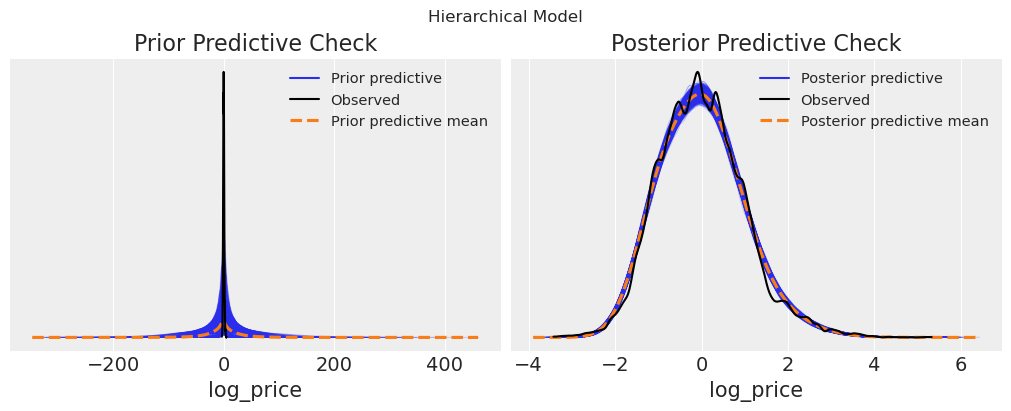

In [78]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
az.plot_ppc(idata_unpool_intercept_hier_slopes, group="prior", observed=True, ax=axes[0])
axes[0].set(xlabel="log_price", title="Prior Predictive Check");
az.plot_ppc(idata_unpool_intercept_hier_slopes, ax=axes[1])
axes[1].set(xlabel="log_price", title="Posterior Predictive Check");
plt.suptitle("Hierarchical Model")
plt.show()

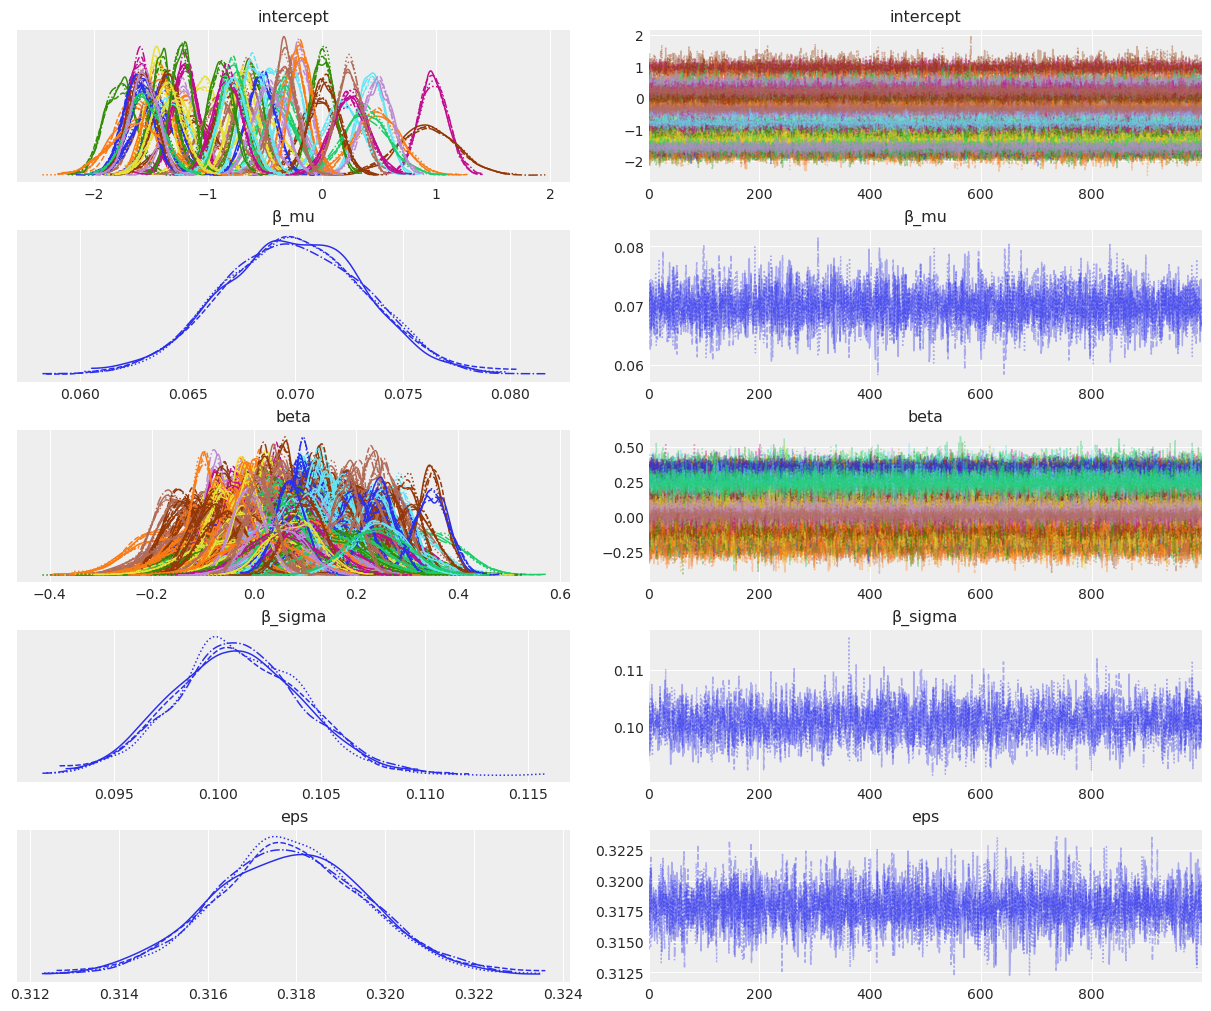

In [79]:
az.plot_trace(idata_unpool_intercept_hier_slopes);

In [80]:
az.summary(idata_unpool_intercept_hier_slopes, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  \
intercept[98001]                -1.61  0.12   -1.84    -1.38        0.0   
intercept[98002]                -1.65  0.17   -1.97    -1.32        0.0   
intercept[98003]                -1.54  0.15   -1.82    -1.27        0.0   
intercept[98004]                 0.97  0.13    0.73     1.21        0.0   
intercept[98005]                -0.03  0.16   -0.32     0.27        0.0   
...                               ...   ...     ...      ...        ...   
beta[98199, log_sqft_above]      0.24  0.06    0.13     0.35        0.0   
beta[98199, sqrt_sqft_basement]  0.04  0.05   -0.05     0.14        0.0   
beta[98199, sqrt_house_age]      0.01  0.03   -0.04     0.07        0.0   
β_sigma                          0.10  0.00    0.10     0.11        0.0   
eps                              0.32  0.00    0.31     0.32        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
intercept[98001]                     0.0  10570.83   2753.81    1.0  
intercept[98002]                     0.0  10997.46   2886.53    1.0  
intercept[98003]                     0.0   7961.58   3106.81    1.0  
intercept[98004]                     0.0   7611.31   2717.40    1.0  
intercept[98005]                     0.0   9587.38   3451.76    1.0  
...                                  ...       ...       ...    ...  
beta[98199, log_sqft_above]          0.0   7575.39   3301.56    1.0  
beta[98199, sqrt_sqft_basement]      0.0   7343.83   3144.85    1.0  
beta[98199, sqrt_house_age]          0.0   8537.22   3390.37    1.0  
β_sigma                              0.0   2847.20   3338.66    1.0  
eps                                  0.0   6290.11   3017.70    1.0  

[1123 rows x 9 columns]

In [81]:
with unpooled_intercept_hierarchical_slopes_model:
    pm.set_data(
        {
            "view": X_test['view'].values,
            "grouped_bedrooms": X_test['grouped_bedrooms'].values,
            "grouped_bathrooms": X_test['grouped_bathrooms'].values,
            "grouped_floors": X_test['grouped_floors'].values,
            "grouped_grade": X_test['grouped_grade'].values,
            "grouped_condition": X_test['grouped_condition'].values,
            "has_view": X_test['has_view'].values,
            "has_basement": X_test['has_basement'].values,
            "log_sqft_living": X_test['log_sqft_living'].values,
            "log_sqft_living15": X_test['log_sqft_living15'].values,
            "log_sqft_lot": X_test['log_sqft_lot'].values,
            "log_sqft_lot15": X_test['log_sqft_lot15'].values,
            "log_sqft_above": X_test['log_sqft_above'].values,
            "sqrt_sqft_basement": X_test['sqrt_sqft_basement'].values,
            "sqrt_house_age": X_test['sqrt_house_age'].values,
            "log_price": y_test['log_price'].values,
            
            "zipcode_idx": df_test["zipcode"].factorize(sort=True)[0]
        }
    )

In [82]:
with unpooled_intercept_hierarchical_slopes_model:
    idata_unpool_intercept_hier_slopes = pm.sample_posterior_predictive(
        idata_unpool_intercept_hier_slopes,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

In [83]:
unpool_intercept_hier_slopes_preds = idata_unpool_intercept_hier_slopes.predictions["log_obs"].mean(dim=("chain", "draw")).data

(array([13.04006018]), array([0.52810788]))

In [84]:
def unstandardize(y: pd.DataFrame, standardizer: Standardizer) -> pd.DataFrame:
    return (y * standardizer._y_sd_scaler.scale_) + standardizer._y_sd_scaler.mean_

In [ ]:
y_test = standardizer.unstandardize(y_test)
unpool_intercept_hier_slopes_preds = standardizer.unstandardize(unpool_intercept_hier_slopes_preds)

In [85]:
rmse = partial(mean_squared_error,  squared=False)

eval_row = ["unpool_intercept_hier_slopes_model",
            *evaluation(
                np.exp(y_test),
                np.exp(uunpool_intercept_hier_slopes_preds),
                mean_absolute_error,
                rmse,
                r2_score)]

In [86]:
df_eval = pd.read_csv('eval.csv')
df_eval.loc[len(df_eval)] = eval_row
df_eval

model            MAE           RMSE     $R^2$
0                    OLS (statsmoels)   85746.831334  155077.242132  0.822943
1                                 OLS   85746.831334  155077.242132  0.822943
2                               Ridge   86091.979736  155664.747791  0.821599
3                               Lasso  167496.552737  280228.190768  0.421851
4                     pooled_l2_model  143504.115035  231115.391420  0.606745
5                     pooled_l1_model  143500.440502  231112.360865  0.606756
6                   unpooled_l2_model   84250.814760  148194.606546  0.838311
7  unpool_intercept_hier_slopes_model   81640.359033  149936.864131  0.834487

In [18]:
features_name = ["view", "grouped_bedrooms", "grouped_bathrooms", "grouped_floors", "grouped_grade",
            "grouped_condition", "has_view", "has_basement", "log_sqft_living", "log_sqft_living15",
            "log_sqft_lot", "log_sqft_lot15", "log_sqft_above", "sqrt_sqft_basement", "sqrt_house_age"]
label = "log_price"

In [21]:
X_train = df_train[features_name].copy()
y_train = df_train[[label]].copy()

X_test = df_test[features_name].copy()
y_test = df_test[[label]].copy()

standardizer = Standardizer(
    columns=X_train.select_dtypes("float").columns,
    labels=y_train.columns
)

In [22]:
X_train, y_train = standardizer.fit(X_train, y=y_train).transform(X_train, y=y_train)
X_test, y_test = standardizer.transform(X_test, y=y_test)

In [23]:
pd.concat([X_train.select_dtypes("float"), y_train], axis=1).describe().T

count          mean       std       min       25%  \
log_sqft_living     17356.0 -3.930174e-16  1.000029 -4.429591 -0.678848   
log_sqft_living15   17356.0  2.010939e-15  1.000029 -4.296049 -0.714748   
log_sqft_lot        17356.0  5.764255e-16  1.000029 -3.042613 -0.511472   
log_sqft_lot15      17356.0 -7.532834e-16  1.000029 -3.068096 -0.524945   
log_sqft_above      17356.0  1.015295e-16  1.000029 -4.030713 -0.718341   
sqrt_sqft_basement  17356.0  5.895261e-17  1.000029 -0.755246 -0.755246   
sqrt_house_age      17356.0 -3.144139e-16  1.000029 -2.545419 -0.795491   
log_price           17356.0 -1.748927e-15  1.000029 -3.436451 -0.689519   

                         50%       75%       max  
log_sqft_living     0.013803  0.690073  4.605585  
log_sqft_living15  -0.071837  0.699464  3.634671  
log_sqft_lot       -0.056904  0.321846  5.434297  
log_sqft_lot15     -0.027897  0.322284  5.826033  
log_sqft_above     -0.091517  0.716477  4.084987  
sqrt_sqft_basement -0.755246  0.990955  4.322611  
sqrt_house_age      0.063219  0.754276  1.877741  
log_price          -0.047873  0.620327  5.333514

In [24]:
RANDOM_SEED = 8296

zipcode_idx, zipcode = df_train["zipcode"].factorize(sort=True)
HIERARCHICAL_COORDS2 = {"slopes": features_name, "zipcode": zipcode}

intercept_mu_sd = 3.0  # weak shrinkage (low regularization)
intercept_sigma_sd = 2.0  # high shrinkage (approx. same sd)

β_mu_sd = 3.0  # weak shrinkage (low regularization)
β_sigma_sd = 1.0  # high shrinkage (approx. same sd)

sd_eps = 1.0

target_accept = 0.95

In [26]:
with pm.Model(coords=HIERARCHICAL_COORDS2) as hierarchical_intercept_hierarchical_slopes_model:
    view = pm.MutableData("view", X_train['view'].values)
    grouped_bedrooms = pm.MutableData("grouped_bedrooms", X_train['grouped_bedrooms'].values)
    grouped_bathrooms = pm.MutableData("grouped_bathrooms", X_train['grouped_bathrooms'].values)
    grouped_floors = pm.MutableData("grouped_floors", X_train['grouped_floors'].values)
    grouped_grade = pm.MutableData("grouped_grade", X_train['grouped_grade'].values)
    grouped_condition = pm.MutableData("grouped_condition", X_train['grouped_condition'].values)
    has_view = pm.MutableData("has_view", X_train['has_view'].values)
    has_basement = pm.MutableData("has_basement", X_train['has_basement'].values)
    log_sqft_living = pm.MutableData("log_sqft_living", X_train['log_sqft_living'].values)
    log_sqft_living15 = pm.MutableData("log_sqft_living15", X_train['log_sqft_living15'].values)
    log_sqft_lot = pm.MutableData("log_sqft_lot", X_train['log_sqft_lot'].values)
    log_sqft_lot15 = pm.MutableData("log_sqft_lot15", X_train['log_sqft_lot15'].values)
    log_sqft_above = pm.MutableData("log_sqft_above", X_train['log_sqft_above'].values)
    sqrt_sqft_basement = pm.MutableData("sqrt_sqft_basement", X_train['sqrt_sqft_basement'].values)
    sqrt_house_age = pm.MutableData("sqrt_house_age", X_train['sqrt_house_age'].values)
    
    zipcode_idx_ = pm.MutableData("zipcode_idx", zipcode_idx)
    
    features = [view, grouped_bedrooms, grouped_bathrooms, grouped_floors, grouped_grade, grouped_condition, 
                has_view, has_basement, log_sqft_living, log_sqft_living15, log_sqft_lot, log_sqft_lot15,
                log_sqft_above, sqrt_sqft_basement, sqrt_house_age]
    
    log_price = pm.MutableData("log_price", y_train['log_price'].values)
#     priors
    ####     HIERARCHICAL INTERCEPT  ###
    intercept_mu = pm.Normal("intercept_mu", sigma=intercept_mu_sd)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=intercept_sigma_sd)
    intercept = pm.Normal("intercept", mu=intercept_mu, sigma=intercept_sigma, dims="zipcode")  # ~N(0, 1) 
    ####     HIERARCHICAL INTERCEPT  ###
    
    ####     HIERARCHICAL SLOPES  ####
    β_mu = pm.Normal("β_mu", sigma=β_mu_sd)
    β_sigma = pm.HalfNormal("β_sigma", sigma=β_sigma_sd)
    β = pm.Normal('beta', mu=β_mu, sigma=β_sigma, dims=("zipcode", "slopes"))  # try Laplace
    ####     HIERARCHICAL SLOPES  ####
#     observational noise
    ε = pm.HalfNormal("eps", sd_eps)
    
    
#     linear regression
    mu = ( intercept[zipcode_idx_] + sum(β[zipcode_idx_, i] * feature for i, feature in enumerate(features)))
#     likelihood
    log_obs = pm.Normal("log_obs", mu=mu, sigma=ε, observed=log_price)
#     sampling
#     idata_hier_intercept_hier_slopes = pm.sample(random_seed=RANDOM_SEED)
    idata_hier_intercept_hier_slopes = pm.sample(target_accept=target_accept, random_seed=RANDOM_SEED)
    idata_hier_intercept_hier_slopes.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata_hier_intercept_hier_slopes.extend(
        pm.sample_posterior_predictive(idata_hier_intercept_hier_slopes, random_seed=RANDOM_SEED)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, intercept, β_mu, β_sigma, beta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15511 seconds.


Creating legend with loc="best" can be slow with large amounts of data.


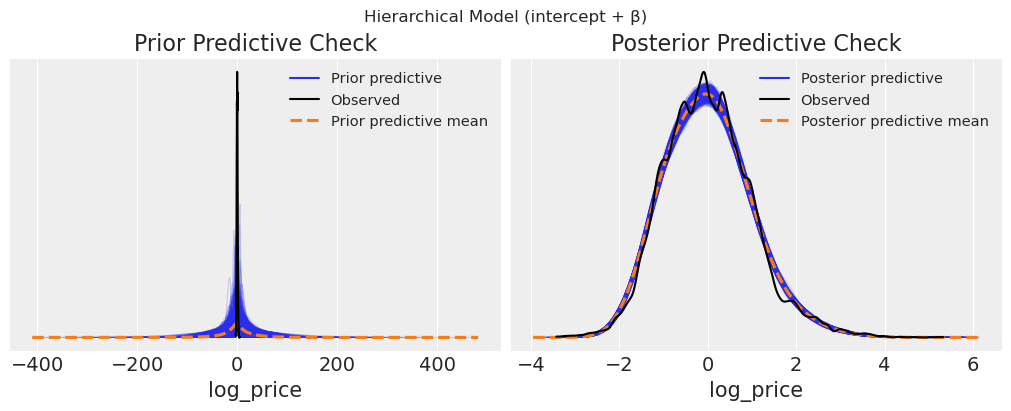

In [27]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
az.plot_ppc(idata_hier_intercept_hier_slopes, group="prior", observed=True, ax=axes[0])
axes[0].set(xlabel="log_price", title="Prior Predictive Check");
az.plot_ppc(idata_hier_intercept_hier_slopes, ax=axes[1])
axes[1].set(xlabel="log_price", title="Posterior Predictive Check");
plt.suptitle("Hierarchical Model (intercept + β)")
plt.show()

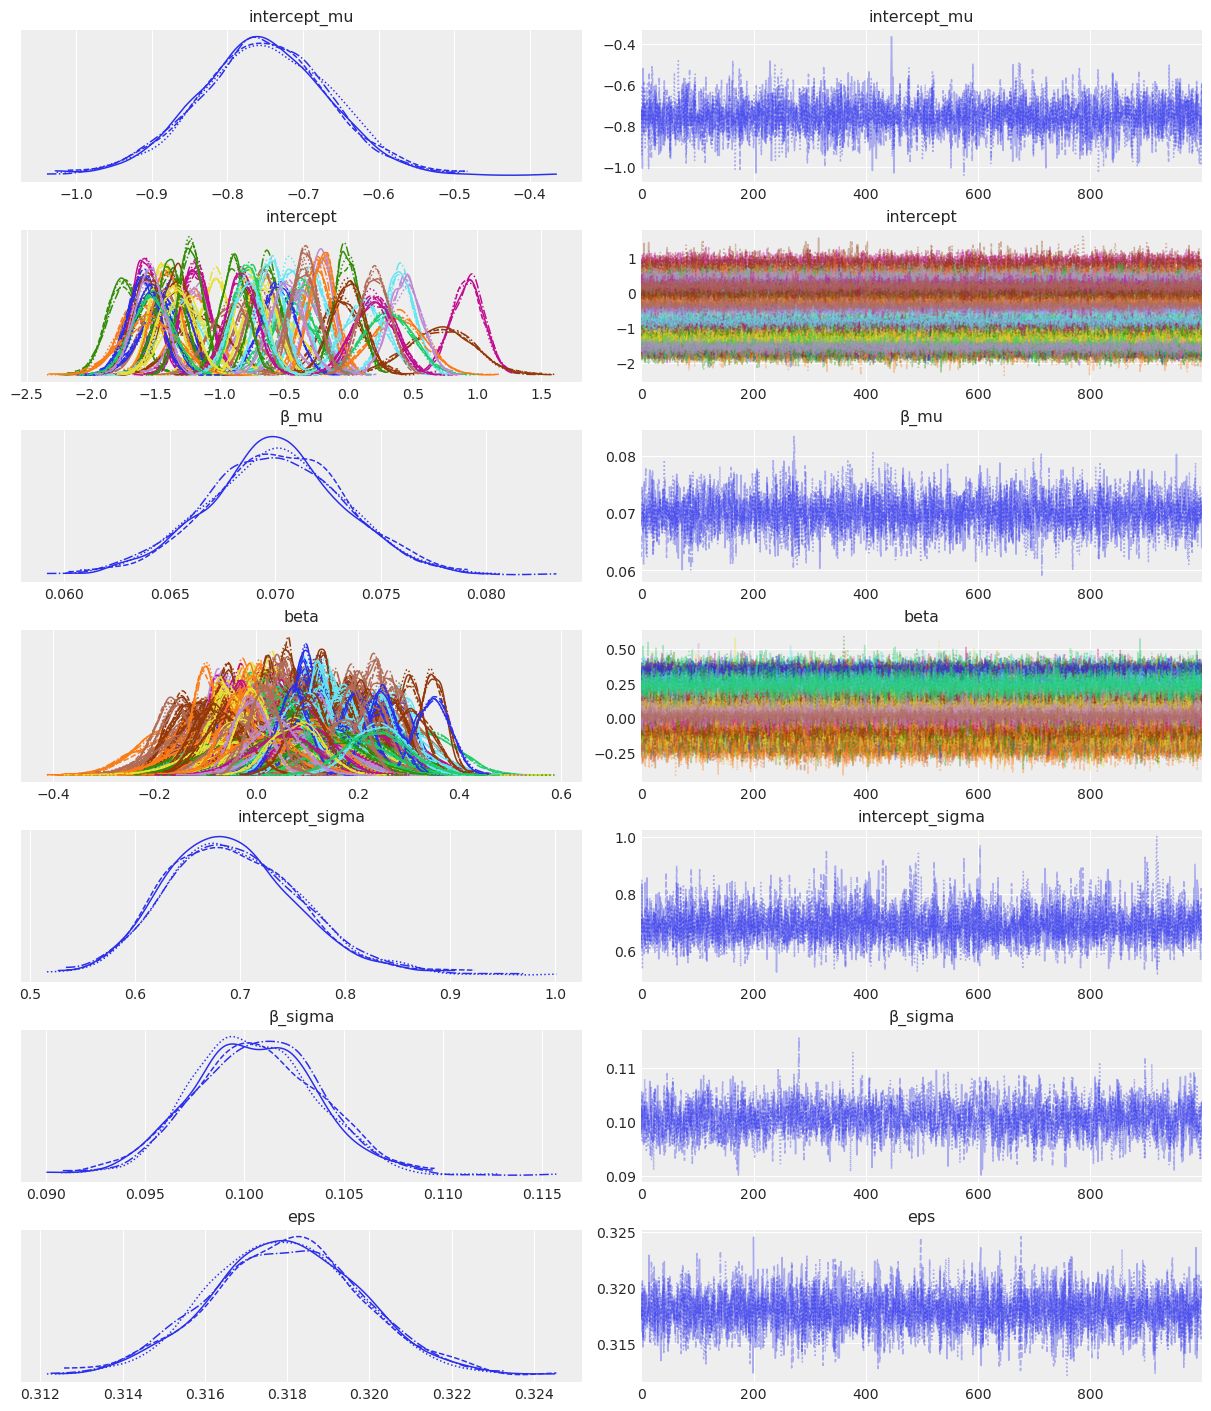

In [28]:
az.plot_trace(idata_hier_intercept_hier_slopes);

In [29]:
az.summary(idata_hier_intercept_hier_slopes, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  \
intercept_mu                    -0.75  0.09   -0.91    -0.59        0.0   
intercept[98001]                -1.60  0.12   -1.82    -1.37        0.0   
intercept[98002]                -1.61  0.17   -1.91    -1.28        0.0   
intercept[98003]                -1.52  0.14   -1.78    -1.24        0.0   
intercept[98004]                 0.92  0.13    0.66     1.14        0.0   
...                               ...   ...     ...      ...        ...   
beta[98199, sqrt_sqft_basement]  0.04  0.05   -0.06     0.13        0.0   
beta[98199, sqrt_house_age]      0.02  0.03   -0.04     0.07        0.0   
intercept_sigma                  0.69  0.06    0.58     0.82        0.0   
β_sigma                          0.10  0.00    0.09     0.11        0.0   
eps                              0.32  0.00    0.31     0.32        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
intercept_mu                         0.0   5690.26   2739.45    1.0  
intercept[98001]                     0.0   5224.72   2985.79    1.0  
intercept[98002]                     0.0   5015.08   2664.28    1.0  
intercept[98003]                     0.0   4848.38   2646.44    1.0  
intercept[98004]                     0.0   4686.90   2832.58    1.0  
...                                  ...       ...       ...    ...  
beta[98199, sqrt_sqft_basement]      0.0   4997.71   2967.99    1.0  
beta[98199, sqrt_house_age]          0.0   6360.63   2857.62    1.0  
intercept_sigma                      0.0   5943.58   2832.26    1.0  
β_sigma                              0.0   2491.61   3060.75    1.0  
eps                                  0.0   5633.19   2251.89    1.0  

[1125 rows x 9 columns]

In [30]:
with hierarchical_intercept_hierarchical_slopes_model:
    pm.set_data(
        {
            "view": X_test['view'].values,
            "grouped_bedrooms": X_test['grouped_bedrooms'].values,
            "grouped_bathrooms": X_test['grouped_bathrooms'].values,
            "grouped_floors": X_test['grouped_floors'].values,
            "grouped_grade": X_test['grouped_grade'].values,
            "grouped_condition": X_test['grouped_condition'].values,
            "has_view": X_test['has_view'].values,
            "has_basement": X_test['has_basement'].values,
            "log_sqft_living": X_test['log_sqft_living'].values,
            "log_sqft_living15": X_test['log_sqft_living15'].values,
            "log_sqft_lot": X_test['log_sqft_lot'].values,
            "log_sqft_lot15": X_test['log_sqft_lot15'].values,
            "log_sqft_above": X_test['log_sqft_above'].values,
            "sqrt_sqft_basement": X_test['sqrt_sqft_basement'].values,
            "sqrt_house_age": X_test['sqrt_house_age'].values,
            "log_price": y_test['log_price'].values,
            
            "zipcode_idx": df_test["zipcode"].factorize(sort=True)[0]
        }
    )

In [31]:
with hierarchical_intercept_hierarchical_slopes_model:
    idata_hier_intercept_hier_slopes = pm.sample_posterior_predictive(
        idata_hier_intercept_hier_slopes,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

In [32]:
hier_intercept_hier_slopes_preds = idata_hier_intercept_hier_slopes.predictions["log_obs"].mean(dim=("chain", "draw")).data

In [41]:
y_pred = pd.DataFrame(hier_intercept_hier_slopes_preds.reshape(-1, 1), columns=["log_price"])

log_price
8      -1.318673
9      -0.671553
10      0.688715
14      0.266181
19     -1.314553
...          ...
21592   0.058719
21593   1.628060
21597   2.328512
21601   0.026556
21606   1.482505

[4257 rows x 1 columns]

In [45]:
y_test = standardizer.unstandardize(y_test)
y_pred = standardizer.unstandardize(y_pred)

In [48]:
rmse = partial(mean_squared_error,  squared=False)

eval_row = ["hier_intercept_hier_slopes_model",
            *evaluation(
                np.exp(y_test),
                np.exp(y_pred),
                mean_absolute_error,
                rmse,
                r2_score)]

In [49]:
df_eval = pd.read_csv('eval.csv')
df_eval.loc[len(df_eval)] = eval_row
df_eval

model            MAE           RMSE     $R^2$
0                    OLS (statsmoels)   85746.831334  155077.242132  0.822943
1                                 OLS   85746.831334  155077.242132  0.822943
2                               Ridge   86091.979736  155664.747791  0.821599
3                               Lasso  167496.552737  280228.190768  0.421851
4                     pooled_l2_model  143504.115035  231115.391420  0.606745
5                     pooled_l1_model  143500.440502  231112.360865  0.606756
6                   unpooled_l2_model   84250.814760  148194.606546  0.838311
7  unpool_intercept_hier_slopes_model   81640.359033  149936.864131  0.834487
8    hier_intercept_hier_slopes_model   81704.606796  150045.491526  0.834247

In [50]:
df_eval.to_csv('eval.csv', index=False)

# Plots (SHAP)

### Global Plots

#### Bar
* global effect of the features 
* the features are ordered from the highest to the lowest effect on the prediction


In [ ]:
# bar plot
shap.plots.bar(shap_values)

#### beeswarm
*  the features are also ordered by their effect on prediction
* we can also see how higher and lower values of the feature will affect the result.
* the little dots on the plot represent a single observation.
* x-axis- represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations.
    * blue color- negative effect
    * red- positive effect
* y-axis- features

In [ ]:
shap.summary_plot(shap_values)
# or 
shap.plots.beeswarm(shap_values)

#### violin

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')

### Local Plots

#### Bar
* the main features affecting the prediction of a single observation, and the magnitude of the SHAP value for each feature.

In [ ]:
shap.plots.bar(shap_values[0])

#### Waterfall
* show how the sum of all the SHAP values equals the difference between the prediction f(x) and the expected value E[f(x)].

In [ ]:
shap.plots.waterfall(shap_values[0])

#### Force
* the positive SHAP values are displayed on the left side and the negative on the right side, as if competing against each other. 
* the highlighted value is the prediction for that observation.

In [ ]:
shap.plots.force(shap_test[0])